In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'code')
from help_funcs import *

In [3]:
import matplotlib

matplotlib.rcParams.update({'font.size': 18})

In [4]:
def plot_raster(all_spikes, tmin = 1000, tmax = 2000):
    
    blue_patch = mpatches.Patch(color='blue', label='PV ChR2 stim')
    black_patch = mpatches.Patch(color='black', label='visual stim')


    order = 1000

    # test out plotting code   
    fig, axes = plt.subplots(3,1,figsize = (12,15),gridspec_kw = {'height_ratios':[4,1,1]})

    ax0 = axes[0]
#     ax0.set_title('contrast=0, local PV stim = 0.1')
    ax0.set_ylabel('Exc',fontsize=15)
    ax0.set_xticks([])
    ax0.set_ylim([0,8*order])
    ax0.set_xlim([tmin,tmax])
    for i in range(8*order):
        spikeTimes = all_spikes[:8*order][i][all_spikes[:8*order][i]<tmax]
        spikeTimes = spikeTimes[spikeTimes>tmin]
        index = i*np.ones(len(spikeTimes))
        ax0.plot(spikeTimes, index, linestyle='',marker='o', color='black',markersize=0.5)
#     ax0.add_patch(plt.Polygon((np.array([[1900,-200],[tmin,0],[tmin+100,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[2400,-200],[tmin+500,0],[tmin+600,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[2900,-200],[tmin+1000,0],[3100,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[3400,-200],[3500,0],[3600,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[3900,-200],[4000,0],[4100,-200]])),clip_on=False,color='black'))

    ax1 = axes[1]
    ax1.set_xlim([tmin,tmax])
    ax1.set_ylim([0,order])
    ax1.set_ylabel('PV',fontsize=15)
    ax1.set_xticks([])
    for i in range(1000):
        spikeTimes = all_spikes[8*order:9*order][i][all_spikes[8*order:9*order][i]<tmax]
        spikeTimes = spikeTimes[spikeTimes>tmin]
        index = i*np.ones(len(spikeTimes))
        ax1.plot(spikeTimes, index, linestyle='',marker='o', color='black',markersize=0.5)
#     ax1.add_patch(plt.Polygon((np.array([[2400,-200],[2500,0],[2600,-200]])),clip_on=False,color='blue'))
#     ax1.add_patch(plt.Polygon((np.array([[3400,-200],[3500,0],[3600,-200]])),clip_on=False,color='blue'))
#     ax1.legend(handles=[blue_patch,black_patch], loc='center left', bbox_to_anchor=(1, 1.7), fontsize=18)

    ax2 = axes[2]
    ax2.set_ylim([0,order])
    ax2.set_xlim([tmin,tmax])
    ax2.set_ylabel('SST',fontsize=15)
    ax2.set_xlabel('time, t (ms)',fontsize=20)
    for i in range(1000):
        spikeTimes = all_spikes[9*order:][i][all_spikes[9*order:][i]<tmax]
        spikeTimes = spikeTimes[spikeTimes>tmin]
        index = i*np.ones(len(spikeTimes))
        ax2.plot(spikeTimes, index, linestyle='',marker='o', color='black',markersize=0.5)

    plt.show()

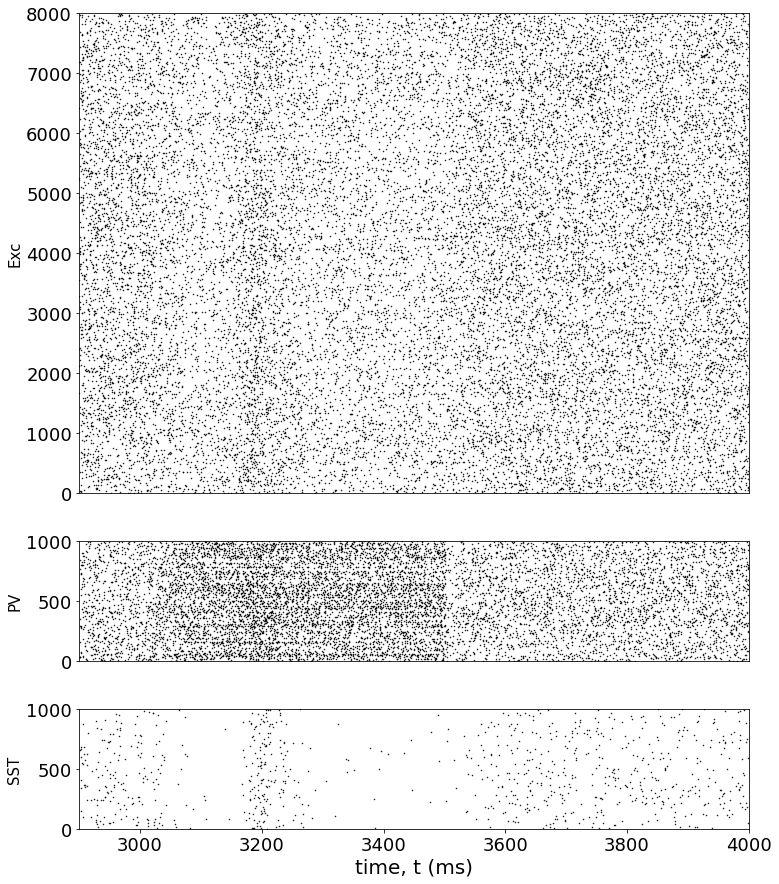

In [9]:
with open('data/v2base4/results_1/PV_0.33_spikes.pickle','rb') as f:
    all_spikes = pickle.load(f)
plot_raster(all_spikes, tmin = 2900, tmax = 4000)

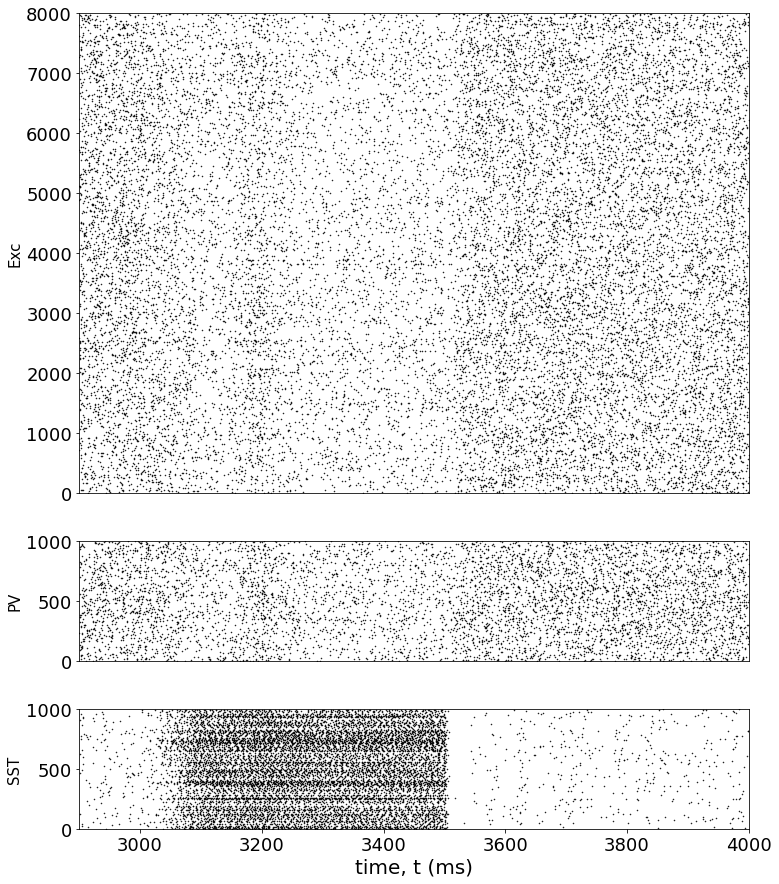

In [8]:
with open('data/v2base4/results_1/SOM_0.33_spikes.pickle','rb') as f:
    all_spikes = pickle.load(f)
plot_raster(all_spikes, tmin = 2900, tmax = 4000)

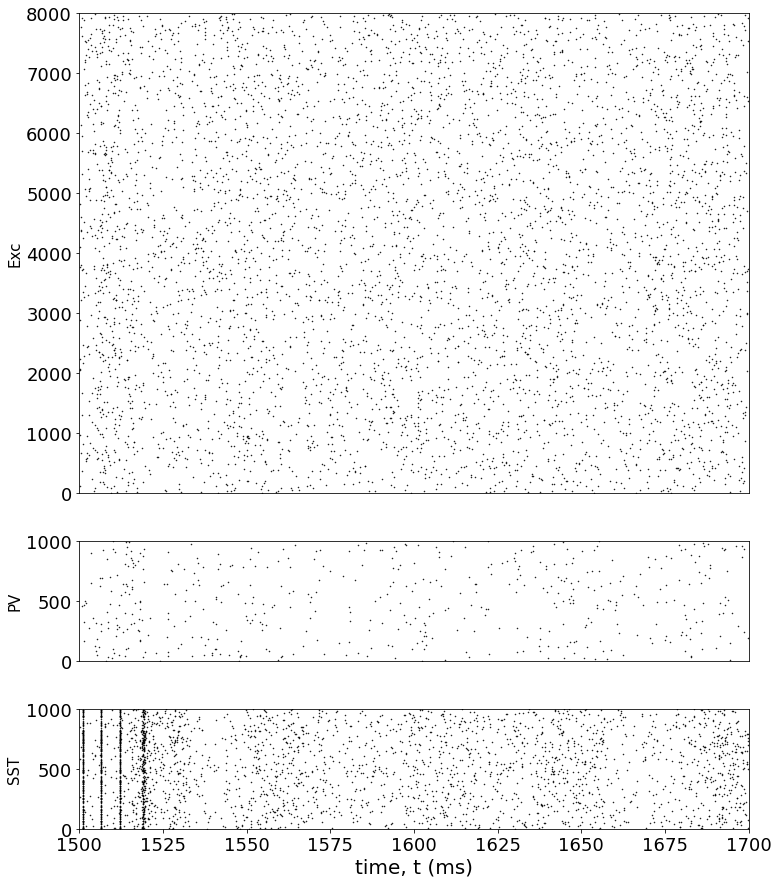

In [5]:
with open('data/base3k/results_1/SOM_0.33_spikes.pickle','rb') as f:
    all_spikes = pickle.load(f)
plot_raster(all_spikes, tmin=1500,tmax= 1700)

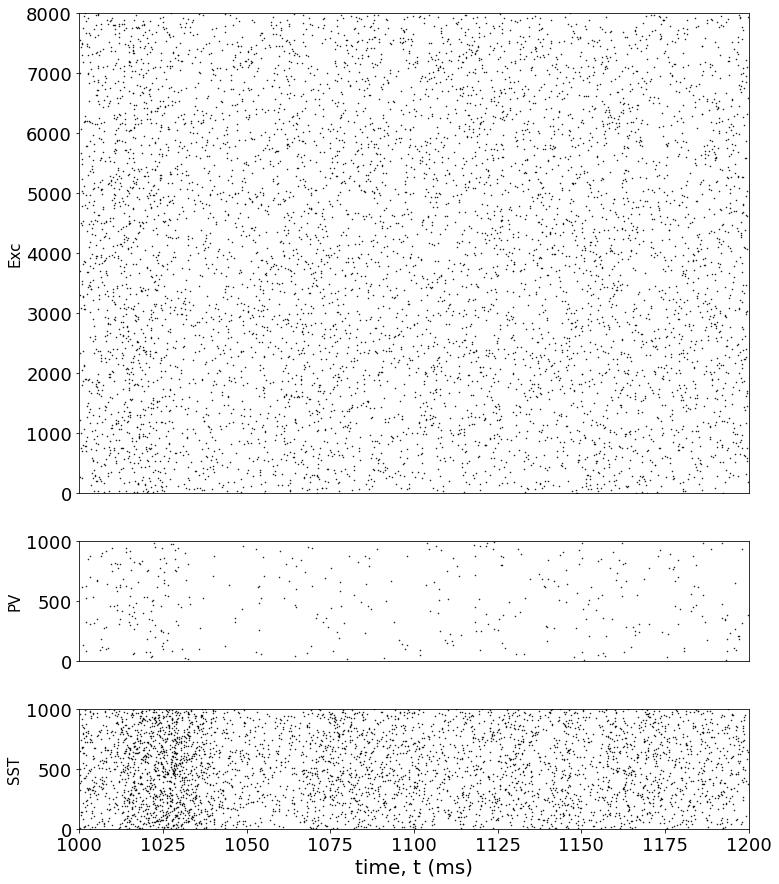

In [9]:
with open('data/base3o/results_1/SOM_0.33_spikes.pickle','rb') as f:
    all_spikes = pickle.load(f)
plot_raster(all_spikes, tmin=1000,tmax= 1200)

In [4]:
def periodic_distance(p1, p2, L=1.0):
    """
    Calculates the periodic distance between two points on a 1x1 2-dimensional plane.

    Parameters
    ----------
    p1 : numpy array
        The first point, with shape (2,).
    p2 : numpy array
        The second point, with shape (2,).
    L : float
        The length of the periodic boundary, default value is 1.0.

    Returns
    -------
    distance : float
        The periodic distance between two points.
    """
    delta = np.abs(p1 - p2)
    delta = np.where(delta > L/2, L - delta, delta)
    return np.sqrt(np.sum(delta**2))


In [6]:
import scipy.stats
def getStimRateMeans(exc_spikes, exc_positions, rates=False, nsecs = 10, delay=0, binlen = 100):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000 + delay
        stop_time = start_time + binlen +delay
        if stop_time > nsecs*1000: break
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        
    assert len(control_times) == len(chr_times)
#     print("NTIMES:", control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.25:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(binlen/1000)*len(control_times)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(binlen/1000)*len(chr_times))
    ctrl_mean = np.mean(control_rates)
    chr2_mean = np.mean(chr_rates)
    
    ctrl_err = scipy.stats.sem(control_rates)
    chr2_err = scipy.stats.sem(chr_rates)
    
    if rates:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err, control_rates, chr_rates]
    else:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err]
    

def getSpontMedians(all_spikes, start_time = 1000., stop_time = 10000.):
    
    exc_spikes = all_spikes[:8000]
    pv_spikes = all_spikes[8000:9000]
    sst_spikes = all_spikes[9000:]
    
    tlen = (stop_time - start_time)/1000.
    
    exc_nspikes = []
    for spikes in exc_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        exc_nspikes.append(len(aa)/tlen)
        
    pv_nspikes = []
    for spikes in pv_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        pv_nspikes.append(len(aa)/tlen)
        
    sst_nspikes = []
    for spikes in sst_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        sst_nspikes.append(len(aa)/tlen)
        
    return np.median(exc_nspikes), np.median(pv_nspikes), np.median(sst_nspikes)

In [7]:
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

# Fit the model
# params, cov = curve_fit(linear_model, contrasts, ctrl_sst_curve[0], sigma=ctrl_sst_curve_e[0])

# Extract the parameters and their errors
# a, b = params
# a_err, b_err = np.sqrt(np.diag(cov))
# print(a,a_err)

In [8]:
import numpy as np
from scipy.optimize import curve_fit

# naka-rushton = (m+((Rm.*(x.^n))./((x.^n) + (c50.^n)))))
# parameter = [Rm, n, c50, m]
# p0 = [150, 5, 0.1, 50]
# Upper = [250, 30, 0.26, 200]
# Lower = [0, 0, 0.04, 0]
p0 = [50, 150, 5, 0.1] 
Upper = [200, 250, 15, 0.2]
# Lower = [0, 0, 0, 0.04]
Lower = [0, 0, 0, 0.05]
bounds = (Lower, Upper)

def naka_rushton(x, m, C, n, k):
    return m + C * (x**n) / (x**n + k**n)

def fit_naka_rushton(x, y, sigma=None, p0 = p0, bounds=bounds):
    params, cov = curve_fit(naka_rushton, x, y, bounds=bounds, sigma=sigma, p0=p0, maxfev = 1000000)
    return params, cov


# def naka_rushton(x, m, C, n):
#     return m + C * (x**n) / (x**n + 0.1**n)

# def fit_naka_rushton(x, y, sigma=None, p0 = [4., 2.0, 2.0]):
#     params, cov = curve_fit(naka_rushton, x, y, sigma=sigma, p0=p0, maxfev = 1000000)
#     return params, cov

# x = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
# y = np.array([0.1, 0.15, 0.3, 0.6, 0.8])

# C, n, k = fit_naka_rushton(contrasts, y)
# print("C =", C)
# print("n =", n)
# print("k =", k)


In [192]:
print(getSpontMedians(all_spikes))

(2.0, 2.0, 4.333333333333333)


In [22]:
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.2, 0.3])
# contrasts = np.array([0.02,  0.2])
ctrl_pv_curve = [[] for i in range(4)]
stim_pv_curve = [[] for i in range(4)]
ctrl_sst_curve = [[] for i in range(4)]
stim_sst_curve = [[] for i in range(4)]

ctrl_pv_curve_e = [[] for i in range(4)]
stim_pv_curve_e = [[] for i in range(4)]
ctrl_sst_curve_e = [[] for i in range(4)]
stim_sst_curve_e = [[] for i in range(4)]

binlen = 100
folder = 'data/base3t/results_49/'
for cont in contrasts:
   
    with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
        all_spikes = pickle.load(f)
    with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
        all_positions = pickle.load(f)
        
    ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen=binlen)
    ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen=binlen)
    ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen=binlen)
    ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err = getStimRateMeans(all_spikes, all_positions, binlen=binlen)
    
    ctrl_pv_curve[0].append(ctrlpv_E_mean)
    ctrl_pv_curve[1].append(ctrlpv_P_mean)
    ctrl_pv_curve[2].append(ctrlpv_S_mean)
    ctrl_pv_curve[3].append(ctrlpv_A_mean)
    ctrl_pv_curve_e[0].append(ctrlpv_E_err)
    ctrl_pv_curve_e[1].append(ctrlpv_P_err)
    ctrl_pv_curve_e[2].append(ctrlpv_S_err)
    ctrl_pv_curve_e[3].append(ctrlpv_A_err)
    
    stim_pv_curve[0].append(stimpv_E_mean)
    stim_pv_curve[1].append(stimpv_P_mean)
    stim_pv_curve[2].append(stimpv_S_mean)
    stim_pv_curve[3].append(stimpv_A_mean)
    stim_pv_curve_e[0].append(stimpv_E_err)
    stim_pv_curve_e[1].append(stimpv_P_err)
    stim_pv_curve_e[2].append(stimpv_S_err)
    stim_pv_curve_e[3].append(stimpv_A_err)
    
    with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
        all_spikes = pickle.load(f)
    with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
        all_positions = pickle.load(f)
        
    ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000])
    ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000])
    ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000])
    ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err = getStimRateMeans(all_spikes, all_positions)

    
    ctrl_sst_curve[0].append(ctrlsst_E_mean)
    ctrl_sst_curve[1].append(ctrlsst_P_mean)
    ctrl_sst_curve[2].append(ctrlsst_S_mean)
    ctrl_sst_curve[3].append(ctrlsst_A_mean)
    ctrl_sst_curve_e[0].append(ctrlsst_E_err)
    ctrl_sst_curve_e[1].append(ctrlsst_P_err)
    ctrl_sst_curve_e[2].append(ctrlsst_S_err)
    ctrl_sst_curve_e[3].append(ctrlsst_A_err)

    stim_sst_curve[0].append(stimsst_E_mean)
    stim_sst_curve[1].append(stimsst_P_mean)
    stim_sst_curve[2].append(stimsst_S_mean)
    stim_sst_curve[3].append(stimsst_A_mean)
    stim_sst_curve_e[0].append(stimsst_E_err)
    stim_sst_curve_e[1].append(stimsst_P_err)
    stim_sst_curve_e[2].append(stimsst_S_err)
    stim_sst_curve_e[3].append(stimsst_A_err)
# contrasts = np.array([ 0.05, 0.1, 0.2, 0.3])

In [274]:
# folder = 'data/base3t/results_5/'
with open(folder + 'Spont_spikes.pickle'%cont, 'rb') as f:
    all_spikes = pickle.load(f)
print(getSpontMedians(all_spikes))

(1.1111111111111112, 2.6111111111111107, 0.4444444444444444)


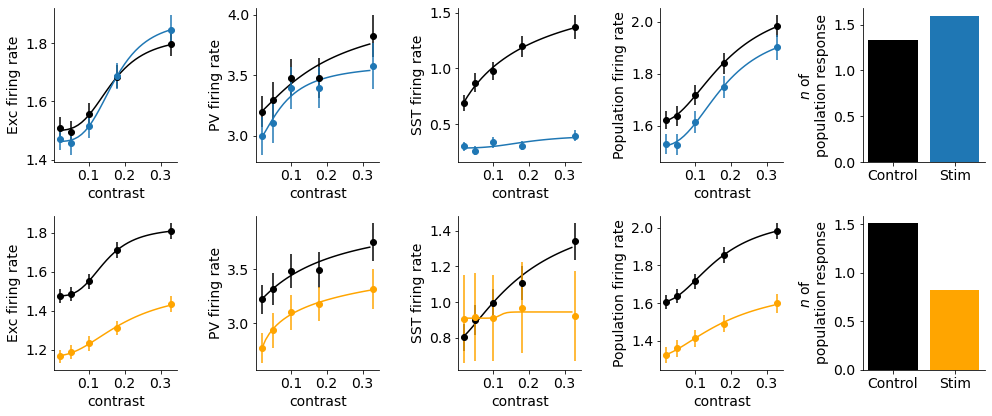

In [23]:
colors = {'ctrl_pv': 'black', 'stim_pv': 'tab:blue', 'ctrl_sst': 'black', 'stim_sst': 'orange'}

# define labels for PV and SST
labels = {'pv': 'PV stimulation', 'sst': 'SST stimulation'}

# define titles for E, P, and S
titles = {'E': 'Exc', 'P': 'PV', 'S': 'SST', 'A':'Population'}

# create subplots
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
xvals = np.arange(0.02,0.33,0.01)
# loop over rows (PV and SST)
for i, y in enumerate(['pv', 'sst']):
    # loop over columns (E, P, and S)
    pop_slopes = []
    pop_errs = []
    for j, z in enumerate(['E', 'P', 'S', 'A']):
        # loop over ctrl and stim
        for x in ['ctrl', 'stim']:
            # get data from X_Y_Z arrays
            data = eval(f"{x}_{y}_curve[{j}]") 
            errs = eval(f"{x}_{y}_curve_e[{j}]") 
#             datp = eval(f"{x}_{y}_datp[{j}]")
            # plot the data with specified color
            ax[i, j].errorbar(contrasts, data, yerr=errs, color=colors[f"{x}_{y}"], fmt='o')
            
            ignor = 0
            params, cov = fit_naka_rushton(contrasts[ignor:], data[ignor:], sigma=errs[ignor:])
#             m, C, n, k = params
# m_err, C_err, n_err, k_err = np.sqrt(np.diag(cov))
            m, C, n, k = params
            m_err, C_err, n_err, k_err = np.sqrt(np.diag(cov))
#             ax[i, j].plot(xvals, naka_rushton(xvals, m, C, n,k), color=colors[f"{x}_{y}"])
            ax[i, j].plot(xvals, naka_rushton(xvals, m, C, n, k), color=colors[f"{x}_{y}"])
            
            if z == 'A':
                pop_slopes.append(C*n/k/4)
                pop_errs.append(0)
#             ax[i, j].plot(contrasts, data, color=colors[f"{x}_{y}"])
        # set title for each subplot
#         ax[i, j].set_title(titles[z])
        ax[i, j].set_ylabel(f"{titles[z]} firing rate")
        ax[i, j].set_xlabel('contrast')
        ax[i,j].spines[['right', 'top']].set_visible(False)
        

    for j,x in enumerate(['ctrl', 'stim']):
        ax[i, 4].bar([j],pop_slopes[j], color=colors[f"{x}_{y}"])
        ax[i, 4].errorbar([j],pop_slopes[j],yerr=pop_errs[j], color=colors[f"{x}_{y}"])
    ax[i,4].set_ylabel('$n$ of\npopulation response')
    ax[i,4].set_xticks([0,1], ['Control', 'Stim'])
    ax[i,4].spines[['right', 'top']].set_visible(False)
#     ax[i,4].text(1,pop_slopes[j]+pop_errs[j]+0.5,'X%.2f'%(pop_slopes[1]/pop_slopes[0]), horizontalalignment='center')

# set labels for each row
# ax[0, 0].set_ylabel(labels['pv'])
# ax[1, 0].set_ylabel(labels['sst'])
plt.tight_layout()

# show the plot
# plt.savefig('result_figs/nl_long.eps')
plt.show()


In [ ]:
# colors = {'ctrl_pv': 'black', 'stim_pv': 'tab:blue', 'ctrl_sst': 'black', 'stim_sst': 'orange'}

# define labels for PV and SST
labels = {'pv': 'PV stimulation', 'sst': 'SST stimulation'}

# define titles for E, P, and S
titles = {'E': 'Exc', 'P': 'PV', 'S': 'SST', 'A':'Population'}

# create subplots
fig, ax = plt.subplots(2, 5, figsize=(14, 6))

# loop over rows (PV and SST)
for i, y in enumerate(['pv', 'sst']):
    # loop over columns (E, P, and S)
    pop_slopes = []
    pop_errs = []
    for j, z in enumerate(['E', 'P', 'S', 'A']):
        # loop over ctrl and stim
        for x in ['ctrl', 'stim']:
            # get data from X_Y_Z arrays
            data = eval(f"{x}_{y}_curve[{j}]")
            errs = eval(f"{x}_{y}_curve_e[{j}]")
#             datp, xx = eval(f"{x}_{y}_datp[{j}]")
            # plot the data with specified color
            ax[i, j].errorbar(contrasts, data, yerr=errs, color=colors[f"{x}_{y}"], fmt='o')
            
            ingor=0
            params, cov = curve_fit(linear_model, contrasts[:], data[:], sigma=errs[:])
            a, b = params
            a_err, b_err = np.sqrt(np.diag(cov))
            ax[i, j].plot(contrasts, contrasts*a + b, color=colors[f"{x}_{y}"])
            
            if z == 'A':
                pop_slopes.append(a)
                pop_errs.append(a_err)
#             ax[i, j].plot(contrasts, data, color=colors[f"{x}_{y}"])
        # set title for each subplot
#         ax[i, j].set_title(titles[z])
        ax[i, j].set_ylabel(f"{titles[z]} firing rate")
        ax[i, j].set_xlabel('contrast')
        ax[i,j].spines[['right', 'top']].set_visible(False)
        

    for j,x in enumerate(['ctrl', 'stim']):
        ax[i, 4].bar([j],pop_slopes[j], color=colors[f"{x}_{y}"])
        ax[i, 4].errorbar([j],pop_slopes[j],yerr=pop_errs[j], color=colors[f"{x}_{y}"])
    ax[i,4].set_ylabel('slope of\npopulation response')
    ax[i,4].set_xticks([0,1], ['Control', 'Stim'])
    ax[i,4].spines[['right', 'top']].set_visible(False)
    ax[i,4].text(1,pop_slopes[j]+pop_errs[j]+0.5,'X%.2f'%(pop_slopes[1]/pop_slopes[0]), horizontalalignment='center')

# set labels for each row
# ax[0, 0].set_ylabel(labels['pv'])
# ax[1, 0].set_ylabel(labels['sst'])
plt.tight_layout()

# show the plot
# plt.savefig('result_figs/rand_p5.eps')
plt.title("0")
plt.show()

In [34]:
import scipy.stats
def getStimRates(exc_spikes, exc_positions):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000
        stop_time = start_time + 40
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        if stop_time > 3000: break
#     print(control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.2:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+40]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+40]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(40/1000)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(40/1000))
#     ctrl_mean = np.mean(control_rates)
#     chr2_mean = np.mean(chr_rates)
    
#     ctrl_err = scipy.stats.sem(control_rates)
#     chr2_err = scipy.stats.sem(chr_rates)
    
    return control_rates, chr_rates

In [219]:
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.2, 0.3])
# contrasts = np.array([0.02,  0.2])
ctrl_pv_curve = [[] for i in range(4)]
stim_pv_curve = [[] for i in range(4)]
ctrl_sst_curve = [[] for i in range(4)]
stim_sst_curve = [[] for i in range(4)]

ctrl_pv_curve_e = [[] for i in range(4)]
stim_pv_curve_e = [[] for i in range(4)]
ctrl_sst_curve_e = [[] for i in range(4)]
stim_sst_curve_e = [[] for i in range(4)]

ctrl_pv_datp = [[] for i in range(4)]
stim_pv_datp = [[] for i in range(4)]
ctrl_sst_datp = [[] for i in range(4)]
stim_sst_datp = [[] for i in range(4)]


# seeds = [12345, 23456, 34567, 45678, 56789, 67890, 78901, 89012, 90123, 1234]
# seeds = [12345, 23456, 34567, 45678, 1, 2, 3, 4]
seeds = [1,2,3,4,5,6,7,8,9]
# seeds = [1,2,4,5,6,8,9]
flist = ['data/base3t/results_%s/'%s for s in seeds]

for cont in contrasts:
    
    E_spikes, P_spikes, S_spikes, A_spikes = [], [], [], []
    E_positions, P_positions, S_positions, A_positions = [], [], [], []
    
    for folder in flist:
        with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
            all_spikes = pickle.load(f)
        with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
            all_positions = pickle.load(f)
        E_spikes += all_spikes[:8000]
        P_spikes += all_spikes[8000:9000]
        S_spikes += all_spikes[9000:10000]
        A_spikes += all_spikes
        
        E_positions += [all_positions[:8000]]
        P_positions += [all_positions[8000:9000]]
        S_positions += [all_positions[9000:10000]]
        A_positions += [all_positions]
        
    

    E_positions = np.concatenate(E_positions, axis=0)
    P_positions = np.concatenate(P_positions, axis=0)
    S_positions = np.concatenate(S_positions, axis=0)
    A_positions = np.concatenate(A_positions, axis=0)
    
    print(A_positions.shape)
        
    ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err, ctrlpv_E_rates, stimpv_E_rates = getStimRateMeans(E_spikes, E_positions, rates=True)
    ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err, ctrlpv_P_rates, stimpv_P_rates = getStimRateMeans(P_spikes, P_positions, rates=True)
    ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err, ctrlpv_S_rates, stimpv_S_rates = getStimRateMeans(S_spikes, S_positions, rates=True)
    ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err, ctrlpv_A_rates, stimpv_A_rates = getStimRateMeans(A_spikes, A_positions, rates=True)
    
    ctrl_pv_curve[0].append(ctrlpv_E_mean)
    ctrl_pv_curve[1].append(ctrlpv_P_mean)
    ctrl_pv_curve[2].append(ctrlpv_S_mean)
    ctrl_pv_curve[3].append(ctrlpv_A_mean)
    ctrl_pv_curve_e[0].append(ctrlpv_E_err)
    ctrl_pv_curve_e[1].append(ctrlpv_P_err)
    ctrl_pv_curve_e[2].append(ctrlpv_S_err)
    ctrl_pv_curve_e[3].append(ctrlpv_A_err)
    ctrl_pv_datp[0].append(ctrlpv_E_rates)
    ctrl_pv_datp[1].append(ctrlpv_P_rates)
    ctrl_pv_datp[2].append(ctrlpv_S_rates)
    ctrl_pv_datp[3].append(ctrlpv_A_rates)
    
    stim_pv_curve[0].append(stimpv_E_mean)
    stim_pv_curve[1].append(stimpv_P_mean)
    stim_pv_curve[2].append(stimpv_S_mean)
    stim_pv_curve[3].append(stimpv_A_mean)
    stim_pv_curve_e[0].append(stimpv_E_err)
    stim_pv_curve_e[1].append(stimpv_P_err)
    stim_pv_curve_e[2].append(stimpv_S_err)
    stim_pv_curve_e[3].append(stimpv_A_err)
    stim_pv_datp[0].append(stimpv_E_rates)
    stim_pv_datp[1].append(stimpv_P_rates)
    stim_pv_datp[2].append(stimpv_S_rates)
    stim_pv_datp[3].append(stimpv_A_rates)
    
    E_spikes, P_spikes, S_spikes, A_spikes = [], [], [], []
    E_positions, P_positions, S_positions, A_positions = [], [], [], []

    for folder in flist:
        with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
            all_spikes = pickle.load(f)
        with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
            all_positions = pickle.load(f)
        E_spikes += all_spikes[:8000]
        P_spikes += all_spikes[8000:9000]
        S_spikes += all_spikes[9000:10000]
        A_spikes += all_spikes
        
        E_positions += [all_positions[:8000]]
        P_positions += [all_positions[8000:9000]]
        S_positions += [all_positions[9000:10000]]
        A_positions += [all_positions]

    E_positions = np.concatenate(E_positions, axis=0)
    P_positions = np.concatenate(P_positions, axis=0)
    S_positions = np.concatenate(S_positions, axis=0)
    A_positions = np.concatenate(A_positions, axis=0)

        
    ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err, ctrlsst_E_rates, stimsst_E_rates = getStimRateMeans(E_spikes, E_positions, rates=True)
    ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err, ctrlsst_P_rates, stimsst_P_rates = getStimRateMeans(P_spikes, P_positions, rates=True)
    ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err, ctrlsst_S_rates, stimsst_S_rates = getStimRateMeans(S_spikes, S_positions, rates=True)
    ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err, ctrlsst_A_rates, stimsst_A_rates = getStimRateMeans(A_spikes, A_positions, rates=True)
     
    ctrl_sst_curve[0].append(ctrlsst_E_mean)
    ctrl_sst_curve[1].append(ctrlsst_P_mean)
    ctrl_sst_curve[2].append(ctrlsst_S_mean)
    ctrl_sst_curve[3].append(ctrlsst_A_mean)
    ctrl_sst_curve_e[0].append(ctrlsst_E_err)
    ctrl_sst_curve_e[1].append(ctrlsst_P_err)
    ctrl_sst_curve_e[2].append(ctrlsst_S_err)
    ctrl_sst_curve_e[3].append(ctrlsst_A_err)
    ctrl_sst_datp[0].append(ctrlsst_E_rates)
    ctrl_sst_datp[1].append(ctrlsst_P_rates)
    ctrl_sst_datp[2].append(ctrlsst_S_rates)
    ctrl_sst_datp[3].append(ctrlsst_A_rates)

    stim_sst_curve[0].append(stimsst_E_mean)
    stim_sst_curve[1].append(stimsst_P_mean)
    stim_sst_curve[2].append(stimsst_S_mean)
    stim_sst_curve[3].append(stimsst_A_mean)
    stim_sst_curve_e[0].append(stimsst_E_err)
    stim_sst_curve_e[1].append(stimsst_P_err)
    stim_sst_curve_e[2].append(stimsst_S_err)
    stim_sst_curve_e[3].append(stimsst_A_err)
    stim_sst_datp[0].append(stimsst_E_rates)
    stim_sst_datp[1].append(stimsst_P_rates)
    stim_sst_datp[2].append(stimsst_S_rates)
    stim_sst_datp[3].append(stimsst_A_rates)


(70000, 2)
(70000, 2)
(70000, 2)
(70000, 2)
(70000, 2)


# Comparison

In [9]:
def get_slope(m,C,n,k):
    cvals = np.arange(0.02,0.33,0.01)
    yvals = naka_rushton(cvals, m, C, n, k)
    
    slopes = []
    for i in range(1, len(cvals)):
        slopes.append((yvals[i]-yvals[i-1])/0.01)
    maxslope = np.max(slopes)
    return maxslope, cvals[slopes.index(maxslope)]

1.6602272471299815 0.680477075527284 2.8725957975564422 0.17119661143648268
3.032211292701792 3.5096470646904354 2.999706318845874 3.226517142567986 3.5096470646904354


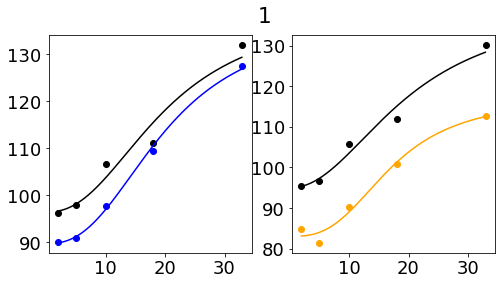

1
1.6941746927120902 1.0690599338910445 1.8129154564354084 0.19999999999999676
3.4432993887893115 3.927302565819213 3.236533938951558 3.3381966119873985 3.927302565819213


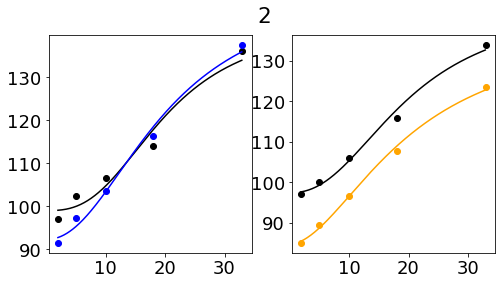

2
1.769985234471377 0.8960764504776128 2.253467563664055 0.19999999999999998
3.232482896809774 4.118574614470205 3.5073549446241525 3.09081836248164 4.118574614470205


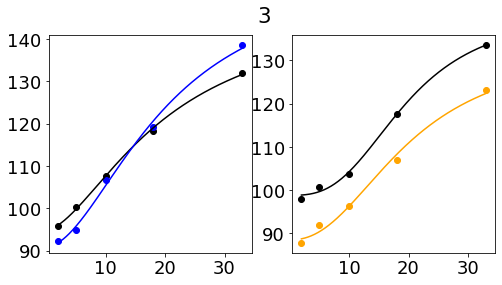

3
1.5237919141086604 1.155180822229456 1.2309360058677719 0.19999999999999998
3.4366090168029384 3.5935952776400715 3.6095470633877857 3.8067057578499153 3.8067057578499153


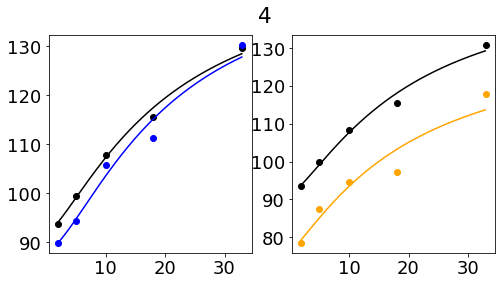

4
1.7357257048772525 0.8985751216414233 2.616055840890611 0.19999999999999998
3.3053868860399183 3.7248732508732285 3.0166454911692675 3.4106991904032213 3.7248732508732285


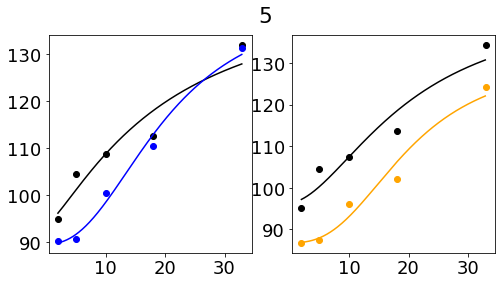

5
1.6417709124465427 0.9209635424828152 2.5075661705172183 0.19999999999999998
3.6654753661764516 3.880127510058129 3.433095506915418 3.3968110524008166 3.880127510058129


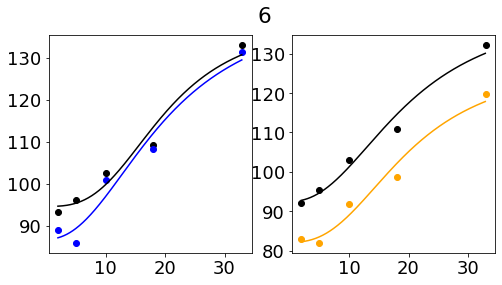

6
1.6185153510174017 0.7870917789764242 3.345980072165019 0.19999999999999998
3.187502670292064 4.286826524283338 3.0635452553366083 3.601126505625052 4.286826524283338


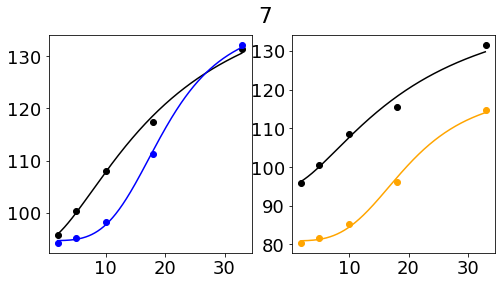

7
1.8023979261751235 0.9773418220475177 3.3274622912794185 0.19999999999999998
2.7773185211083184 4.585681385902207 2.9219525250530953 4.451777573317672 4.585681385902207


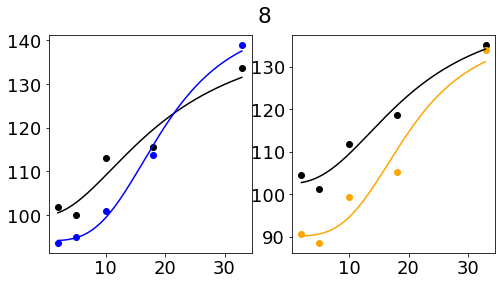

8
1.6353725187179877 0.9411915644001564 2.3747164960498712 0.19999999999999998
3.411996647341109 3.9115741054432718 3.2980116295034723 3.3521705714275596 3.9115741054432718


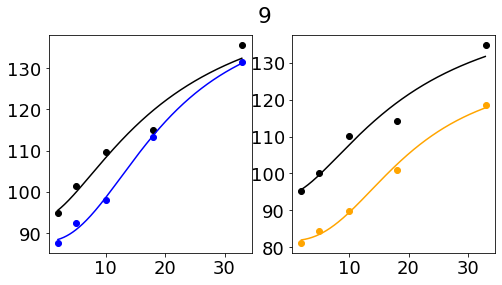

9
1.6646903920628071 0.7906751030616442 2.776208303580084 0.19999999999999998
3.488465076389602 3.479047632601695 4.406578181999432 3.129941948144088 4.406578181999432


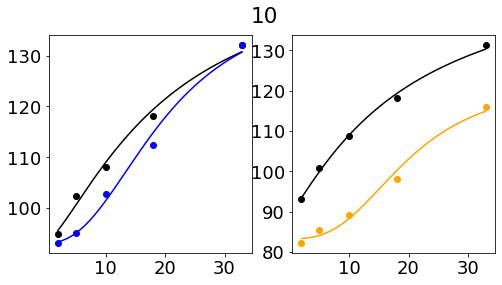

10
1.7477305388785604 0.8498615891244631 3.015276118777548 0.19999999999999998
3.3538226638164748 4.44196132621455 3.4022390027301785 3.575729644169412 4.44196132621455


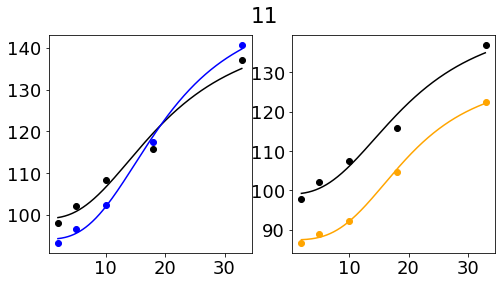

11
1.6656467154859382 0.9735060490663087 2.4713692157564155 0.1986528317617507
3.8930281623680507 4.476231295664901 3.9094619604206127 3.5768204035365514 4.476231295664901


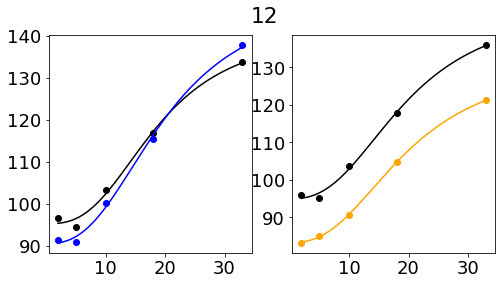

12
1.7597687145961192 0.9808461336020451 2.2404528529752543 0.19999999999999998
3.4325783736762094 3.3191773071016506 3.812145822831514 3.3708446978522044 3.812145822831514


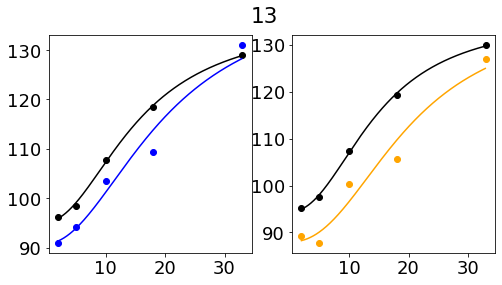

13
1.693078377179512 0.8025834431062921 3.2191419117009765 0.19999999999999998
4.924942451710956 3.493822736892116 4.235933562132255 3.5594787504267256 4.924942451710956


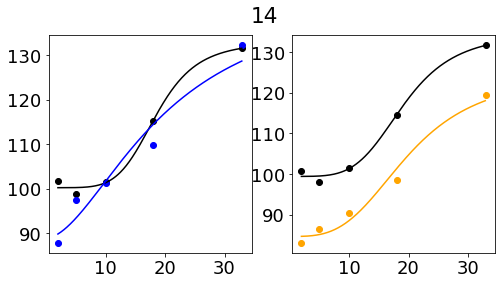

14
1.5808679139068247 1.009343865661275 1.3284980694411266 0.19999999999999998
2.970992637741343 3.8444294573515947 3.1715445263779785 3.1699908457947013 3.8444294573515947


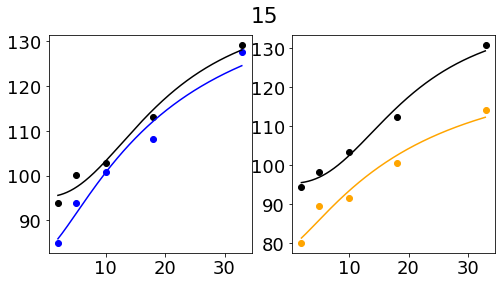

15
1.699970350426608 0.8293196360189103 3.0416687447388666 0.19999999999999998
3.0594546802453326 3.9488923662750253 3.107305537435723 3.511097698308774 3.9488923662750253


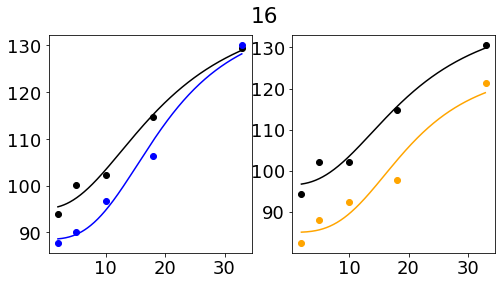

16
1.6365677152087066 0.8761742843062867 2.9109488775282655 0.19999999999999854
3.615500903109181 4.095220167281166 3.6211883637482067 3.5933679348234993 4.095220167281166


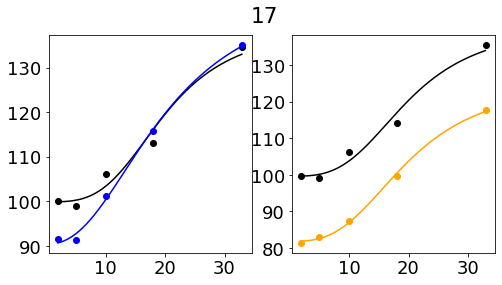

17
1.739495504205974 0.982626175448458 2.2272434168481627 0.19999999999999998
3.1662323372646295 4.330789841661087 3.241653327870253 3.365476561745817 4.330789841661087


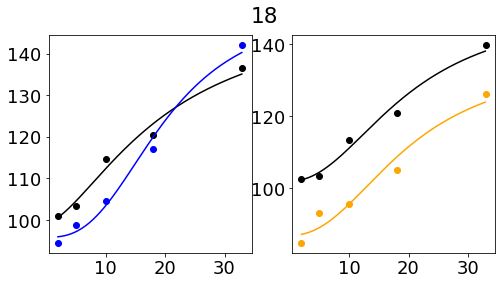

18
1.6724900556167899 0.950174534458682 2.495166067355936 0.19999999999999998
4.980334139534559 3.7035399233353417 3.2460376203931496 3.492556363975674 4.980334139534559


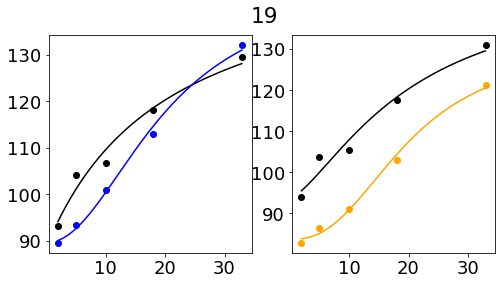

19
1.6081158130921456 1.0359923823774722 1.4623274082998883 0.19999999999999998
3.377954723274623 4.825017429932421 3.289608416567047 3.1620158959731137 4.825017429932421


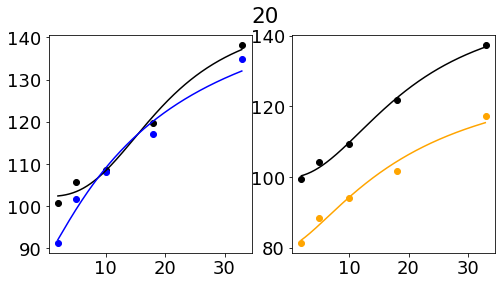

20
1.6690955794521416 0.876976762756189 2.5942705160524473 0.1999999999999999
3.0011338347286864 4.074659558074645 2.990002568168526 3.3102054824193594 4.074659558074645


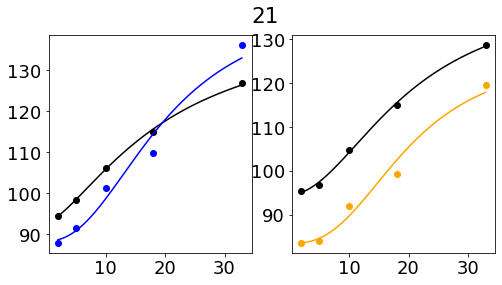

21
1.6025116343556203 0.8696493041063195 2.40640253392519 0.1943288325692799
3.6141014230954838 3.833840141063627 3.1652890482460894 3.2150842248993783 3.833840141063627


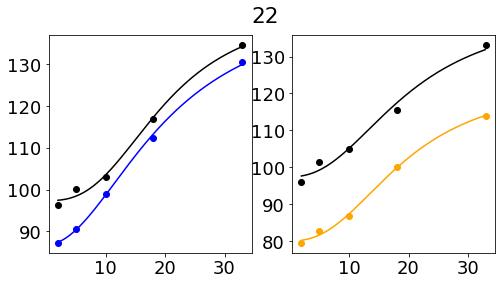

22
1.7188863188998769 1.051892958524279 1.7736127458485533 0.19999999999999998
3.612189866706217 3.755541435723897 3.898356368306688 3.2650462813077485 3.898356368306688


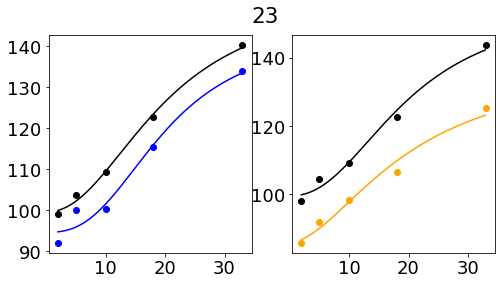

23
1.6984268616704181 0.8755723135482525 2.5076044732779352 0.19999999999999998
3.486709000403243 4.001267503910078 3.330982915669889 3.229427579299493 4.001267503910078


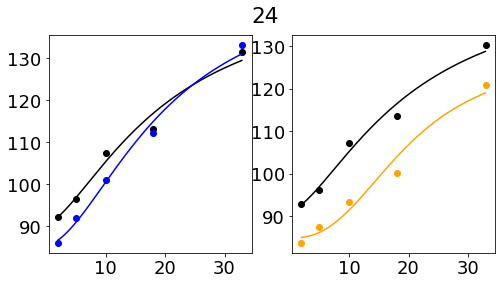

24
1.5221367793916565 1.0892837558478639 1.51652687999677 0.19999999999999998
3.5456744476877633 3.751136775808761 3.6278369859550574 3.309671350303467 3.751136775808761


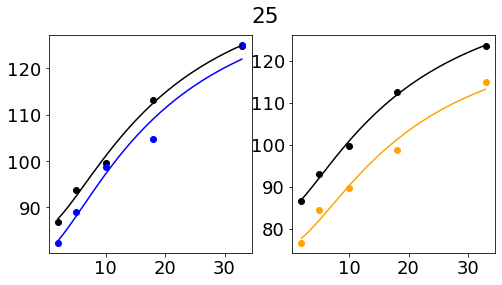

25
1.7235011363593895 0.8081924670649463 3.4876449203693047 0.19999999999999998
5.405915503918846 3.9606578499777445 6.933464203430328 3.8207674214639553 6.933464203430328


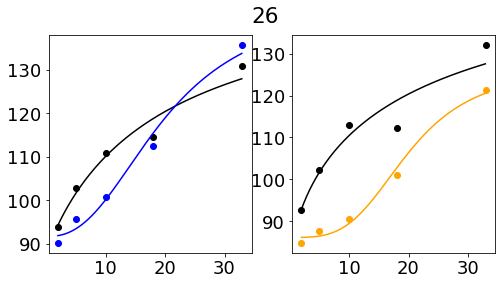

26
1.5957022430817598 0.7960994912699099 2.6363113487650147 0.19999999999999998
3.5118745196472734 3.6766482762942587 3.685756444218402 3.0371999832621954 3.685756444218402


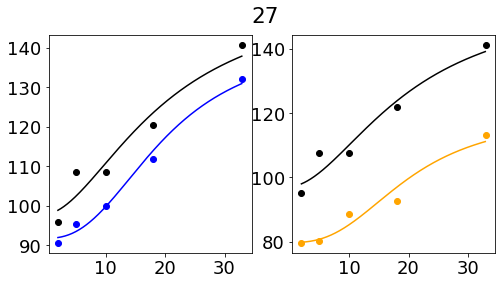

27
1.516216085995339 1.0928243109785922 1.257055375478151 0.19999999999999124
3.021256112067272 4.2181891503549895 3.2161202807108324 3.5465528256715118 4.2181891503549895


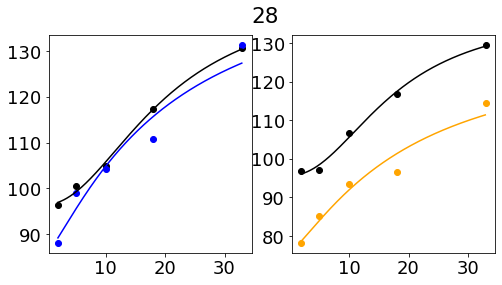

28
1.694475468323635 0.960531986327567 1.7641440214683997 0.19999999999999998
4.2983547868623795 3.498717287244646 3.612511778019112 2.9776620065276704 4.2983547868623795


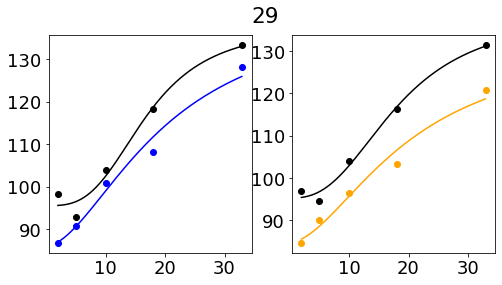

29
1.7890958593227047 0.9211277878603361 2.3927341427691404 0.19999999999999998
3.247131871682596 3.778754373982185 3.3495100140517486 3.2953588413183965 3.778754373982185


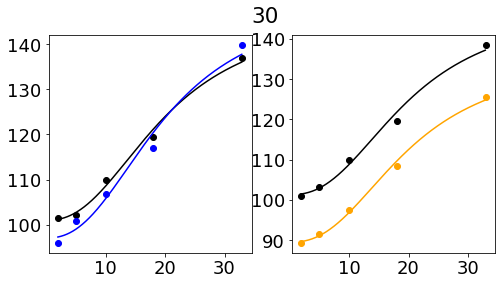

30
1.6910556334473368 1.065499553524754 2.19972432454573 0.19999999999999998
3.7036084493988763 3.9834518463405466 3.5715929741889862 3.6266256331569435 3.9834518463405466


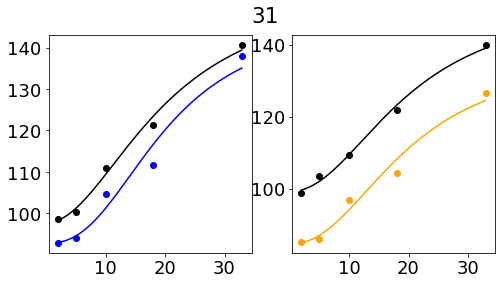

31
1.6359063825143785 0.9819545071654369 2.8378452710837245 0.19999999999999998
3.058594461087516 4.145958054017074 3.157185282361974 3.951946346692936 4.145958054017074


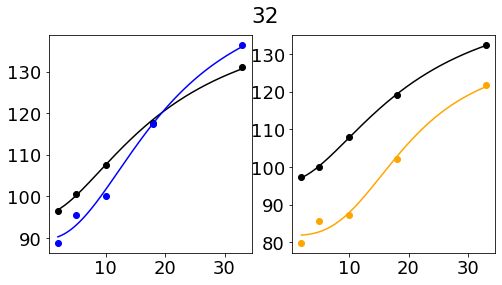

32
1.6892902920078219 0.6608646866579192 3.3677287589669227 0.16591743753737387
3.4779514975266324 4.4025451752177425 3.348258951859018 3.657629447063715 4.4025451752177425


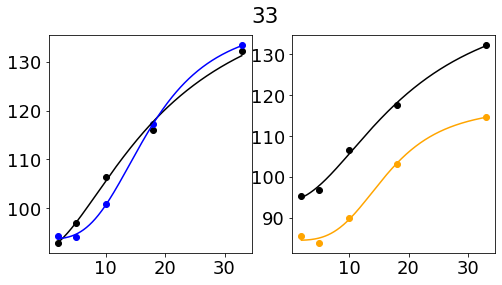

33
1.5491743373297446 0.9528373635927174 2.2419106693750037 0.19999999999999998
4.041719082367923 4.072833411819454 4.127143400110445 3.2759386567317694 4.127143400110445


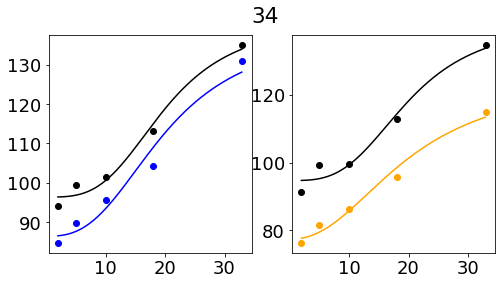

34
1.643229991733134 0.7037782544996155 3.56204224531322 0.17766229173014214
3.794048925514115 3.731516467523055 3.8199121318778673 3.8097976055310623 3.8199121318778673


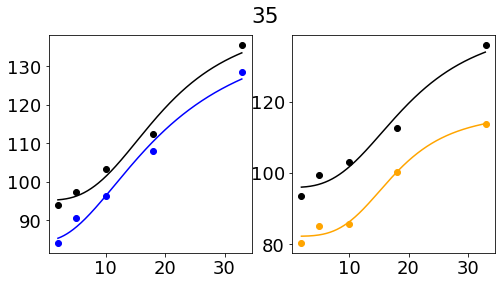

35
1.6444789100877797 0.9483151969620387 3.1975366695750775 0.19999999999999998
2.844242528246177 4.549670761882085 2.917221987163998 4.182818561111024 4.549670761882085


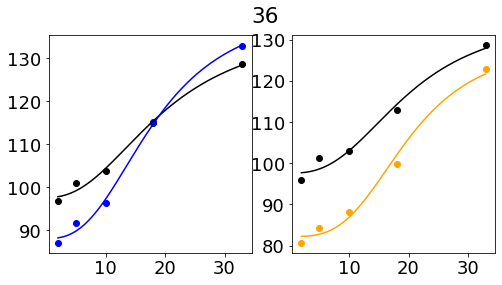

36
1.5801378879645351 0.8562390350067743 2.7066766436016008 0.19999999999999996
3.208092060480272 4.129237347144876 3.383944693889207 3.3244331601030463 4.129237347144876


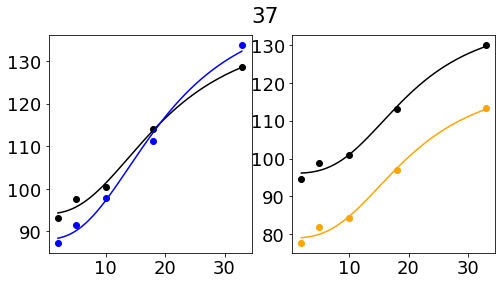

37
1.6137558403659307 0.7944622452847052 2.405628349333484 0.19999999999999998
3.4237287972466834 3.824094409529577 3.4454293697391503 2.851150610882791 3.824094409529577


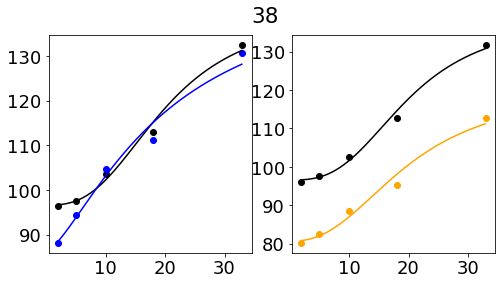

38
1.6090046645492648 0.8213036708821675 2.9989736973459364 0.19895768349485363
3.1198182878355407 3.8560737087416808 3.0056641455919575 3.4616788993301784 3.8560737087416808


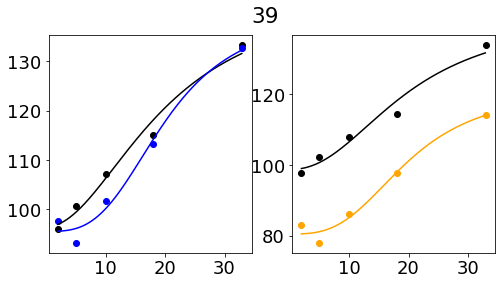

39
1.6996087502250863 0.9295115785926945 2.1181628050667225 0.19999999999999998
4.213943256383068 3.783104494317069 3.9591425281685577 3.1017353348941956 4.213943256383068


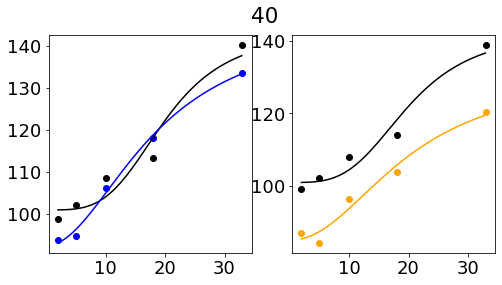

40
1.6905462912651106 0.8915870945762108 2.737335926090338 0.19999999999999998
3.0070716626804828 3.9148870976652983 3.0034687090441547 3.491717250383908 3.9148870976652983


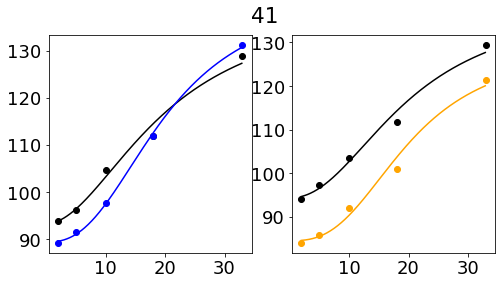

41
1.5254610520644944 0.970524625709238 1.6649821449874838 0.19999999999999998
3.377436958529545 3.70241623035521 3.4562508817648663 2.9702584510203245 3.70241623035521


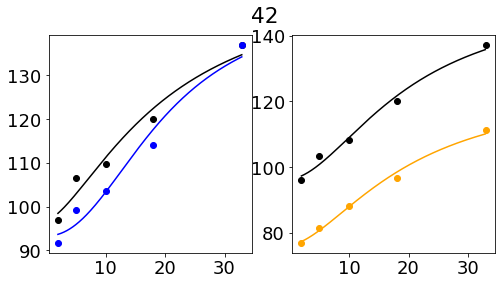

42
1.7042986787053076 1.0376338887290117 2.807632194401057 0.19999999999999998
4.111215015990144 4.336353852479258 4.462078032448158 4.142625654004295 4.462078032448158


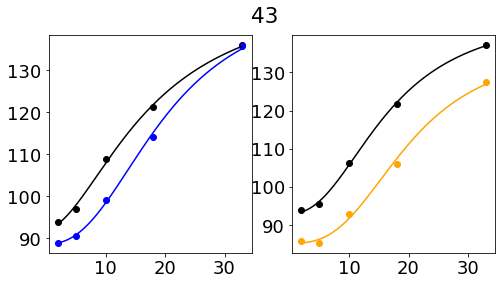

43
1.7197344561006787 1.0738676631569504 2.3827917283437237 0.1999999999999923
4.716946370381869 4.3206601124544 5.204564386257893 3.8323937737217317 5.204564386257893


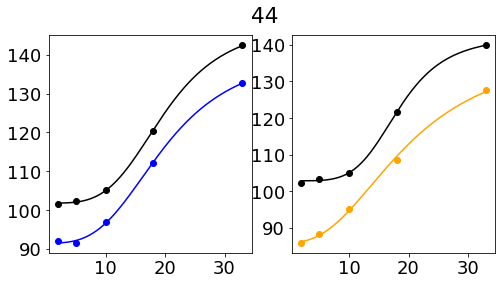

44
1.7360497056613495 0.7051093782984548 4.063218357715385 0.1856373748183873
3.432214853589688 3.858700363513856 3.3664261873346923 4.096438991882034 4.096438991882034


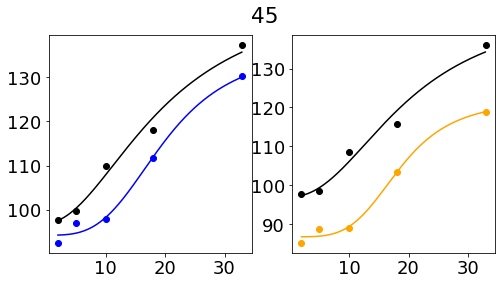

45
1.5091117910427378 0.9719871266097609 1.88537204926794 0.19999999999999998
2.8146651783103938 3.588171202707846 3.0819050560815686 3.0785049366981454 3.588171202707846


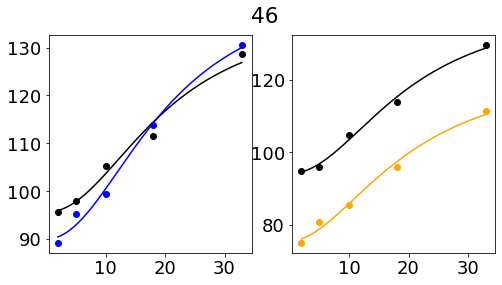

46
1.648318578555113 0.9733185578000764 2.125674164847644 0.18605958357575603
3.182799490543564 4.7793441690636485 3.382181259756001 3.497969447695759 4.7793441690636485


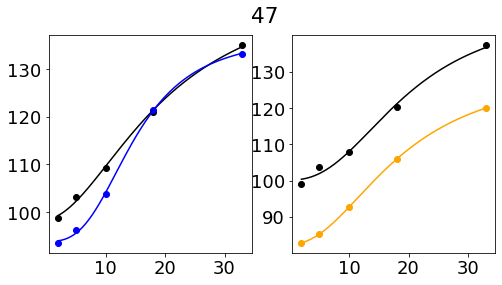

47
1.586084273463197 0.9388722518745026 2.245136273968518 0.16180674205073695
3.463214878670895 3.9556291751015493 4.166764714925142 3.9967533098536734 4.166764714925142


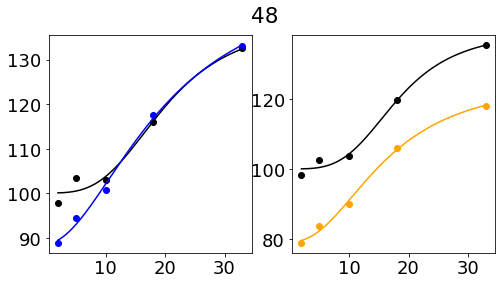

48
1.5695389591220061 0.7524030322969172 2.392019422164016 0.19999999999999904
2.874493568673109 3.6728061126313882 2.8497834321854487 2.691269922582684 3.6728061126313882


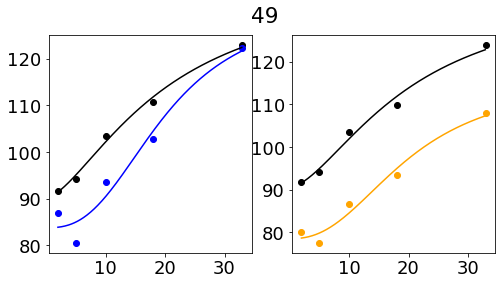

49
1.731596286533732 0.7793528835430307 2.2923051757172073 0.19999999999999998
3.0524365174154244 3.6198307502880667 2.902548314908593 2.7170381113053255 3.6198307502880667


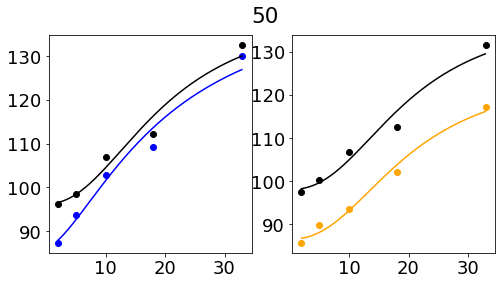

50
1.7011825743274107 1.046955612039557 2.3866011831639624 0.19999999999999998
3.5825336011469755 3.9317332927231607 3.6183243282442934 3.7398682749784973 3.9317332927231607


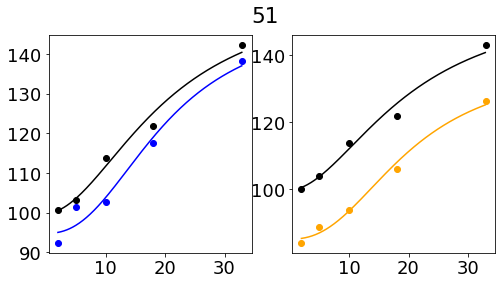

51
1.6109994357451378 0.9991296223791073 2.20364807350326 0.19999999999999998
3.36380516950725 3.939359211206339 3.2089552270638144 3.403794556163997 3.939359211206339


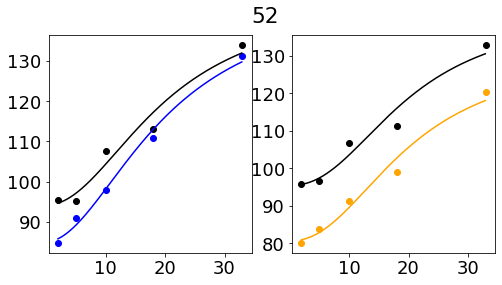

52
1.6077945762364718 0.9169127577950136 2.0821105632433143 0.19999999999999998
3.9270478336028036 3.289403795298851 3.3603175434702814 3.0310615948816455 3.9270478336028036


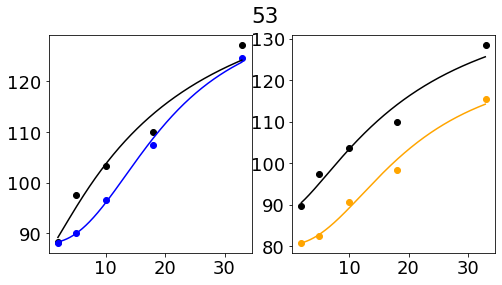

53
1.6400596398135077 1.0420258296689378 2.0472453356843596 0.19999999999999998
3.3861560866023765 3.8257118610352414 3.1431110488230107 3.416566413948474 3.8257118610352414


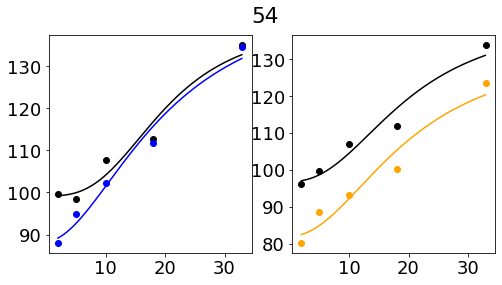

54
1.6941159469527391 0.8613939725336159 2.5258253745254526 0.19999999999999998
3.189423587572726 3.4030848532999425 3.1313285019046067 3.1929973610862694 3.4030848532999425


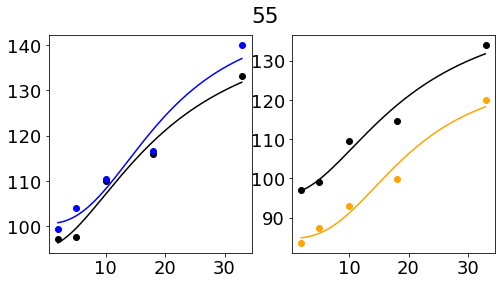

55
1.5697738063507871 1.0925996835976473 1.6477319227081426 0.1999999999999993
3.4719882262074897 3.6580753908423524 3.4488912815639594 3.3391962286546395 3.6580753908423524


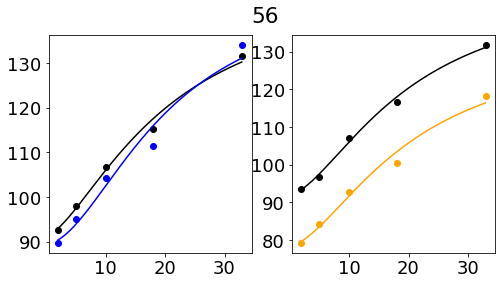

56
1.640461534703716 1.0590275411320602 2.3020295124628287 0.19999999999999998
3.2675708680853344 4.3520627610198925 3.1340256198735705 3.7017128749367023 4.3520627610198925


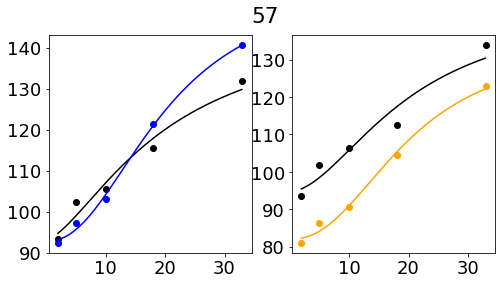

57
1.6536419480140672 1.0571672633146245 1.43669859245488 0.19999999999999998
3.1254641668265304 3.734582810580589 3.064651352657455 3.232190654083422 3.734582810580589


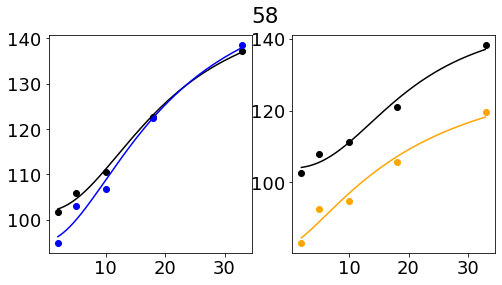

58
1.5972981292756547 0.7933494095129373 2.5259268771008783 0.19999999999999693
2.933531836109715 3.239565954043755 2.8815267724046745 2.940852230781754 3.239565954043755


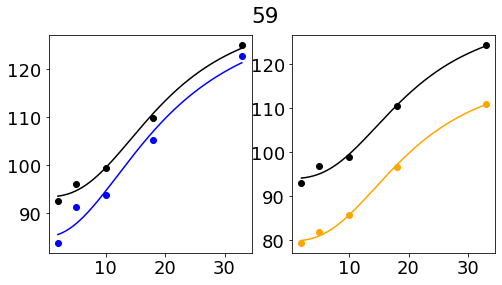

59
1.7081759357896176 0.87255436767708 3.1189694495894944 0.19999999999999998
3.1654039273215417 3.8069865816578563 3.1571771046431607 3.770998273301074 3.8069865816578563


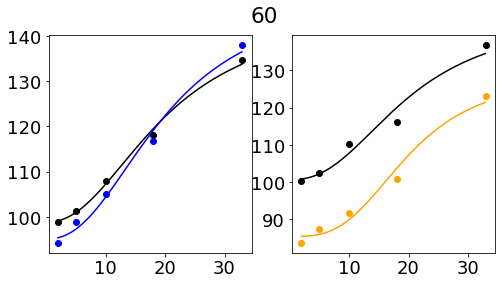

60
1.553988573562841 0.9817236608619332 1.9948974520978775 0.19999999999999685
3.526621327347179 3.5929554902607297 3.0272206785138867 3.1830882474777056 3.5929554902607297


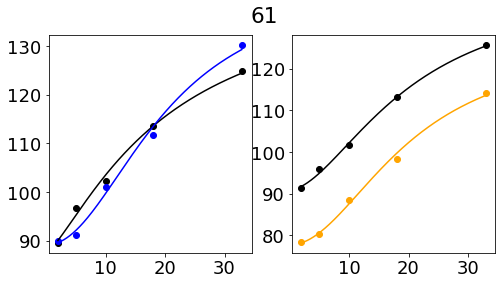

61
1.8437880383161378 0.7057814168951045 3.5217658625603225 0.14428133517581185
3.6977335014614976 4.634328634611418 3.5353573972381813 4.659960262657847 4.659960262657847


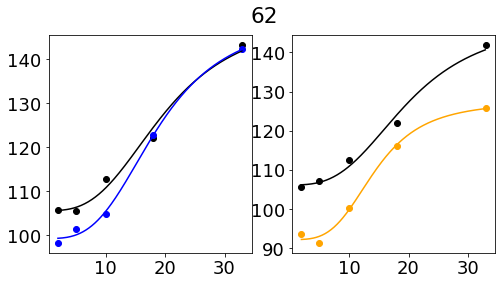

62
1.6897246440388631 0.9152072376844829 2.741782999483406 0.19999999999999998
3.5888711585548627 4.2860165723873855 3.3194327258820877 3.588670085232293 4.2860165723873855


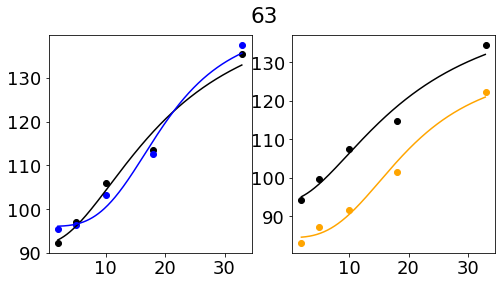

63
1.631279501571926 1.0100437252247458 2.3900010763953783 0.19660678093006081
3.526460158464939 4.109502363237905 3.4293600066826357 3.67504115320354 4.109502363237905


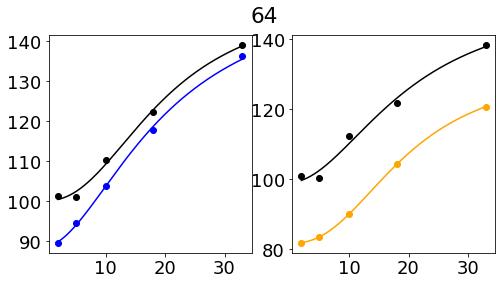

64
1.6277288214721275 0.9863099367708277 1.815602618541445 0.19999999999999998
3.394045137716928 3.542824063892791 3.6544694996519578 3.0815567078959605 3.6544694996519578


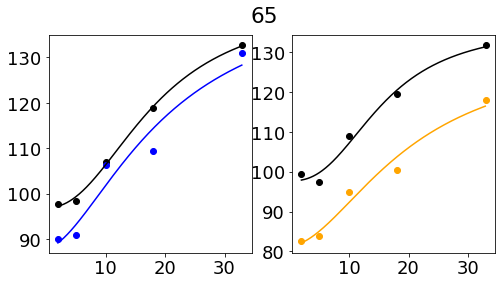

65
1.6021731908325112 1.083767546667031 2.0708799736580263 0.19389407269491785
2.8919731506201085 4.384807664751356 4.0950094162968576 3.6880792264538664 4.384807664751356


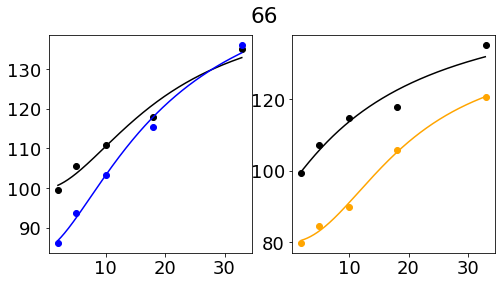

66
1.5866017618068684 0.9780856882824489 1.9694074448300973 0.19999999999999998
3.7736075122984047 3.7241898184733335 3.622301667288319 3.1529523361777834 3.7736075122984047


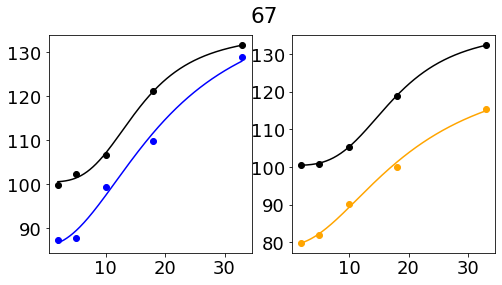

67
1.6501083543121464 1.0217837208192149 2.017638195615117 0.19999999999999993
3.575024378447944 4.042800371616284 3.6240171631370277 3.3294964817933703 4.042800371616284


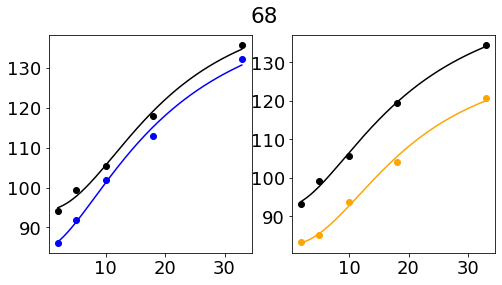

68
1.64986727164134 0.861311779823024 2.9304016097444463 0.19999999999999993
3.4068600965356577 4.2935710746993205 3.42972213196604 3.5497151782408753 4.2935710746993205


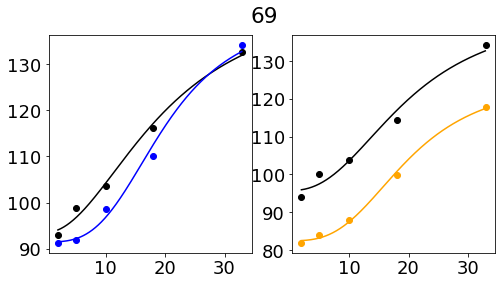

69
1.7958388279760809 0.6375227237130852 5.924449221889991 0.19999999999999998
3.4783425384614652 2.9385846210072675 3.6322900200638664 4.831275509137667 4.831275509137667


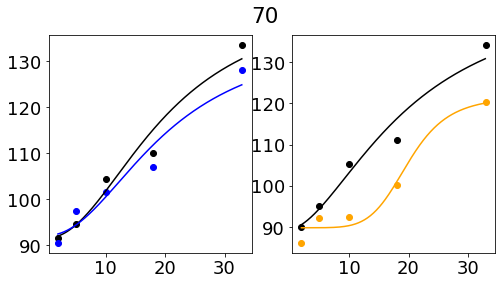

70
1.6078122963360812 1.174501462774959 1.3924597112183543 0.19999999999999998
3.370434227247454 7.432714286899889 3.5786651641990463 3.623432408894467 7.432714286899889


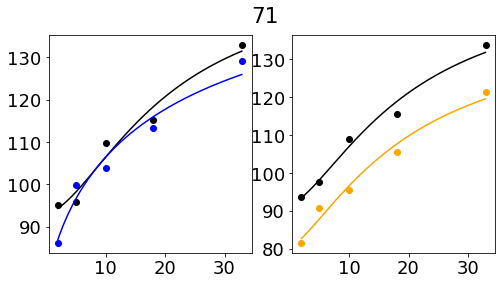

71
1.6425679048273416 0.9176074702937115 2.9307543099455517 0.19999999999999998
2.959516405220075 3.787611024962434 3.2011530778270014 3.7820591253773905 3.787611024962434


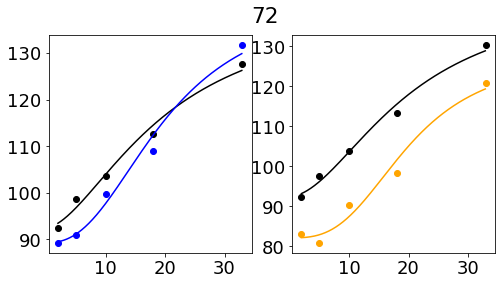

72
1.617024645080718 1.0562784779042367 1.935756802194931 0.19999999999999998
3.7471070247240945 4.293687553113346 3.6502057611272676 3.3777861733182313 4.293687553113346


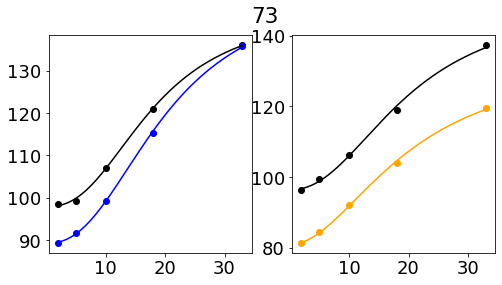

73
1.6114838694838514 0.9217108948175669 1.9174428113202737 0.19760300535217828
3.4872437287136737 3.7185400244930555 3.568866580034724 2.9728105369579705 3.7185400244930555


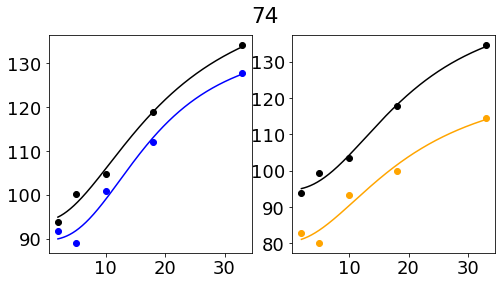

74
1.6243181996847245 1.1038524284319797 1.9178701994403051 0.19999999999999998
3.201068551711428 3.756440879152878 3.44662958884423 3.515908216262753 3.756440879152878


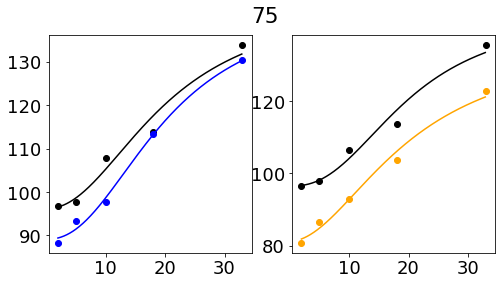

75
1.532540152272091 0.8293738782435327 2.4600342624477864 0.15269350934372478
5.437327719380702 3.7638844821565876 3.458395690843341 3.9534275577764566 5.437327719380702


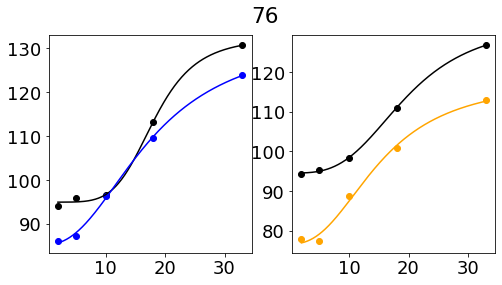

76
1.6064415848485618 0.7927955001297144 2.6227583765132096 0.19999999999999998
2.92034258626086 3.31120777822842 3.162863660076276 3.0143073366926565 3.31120777822842


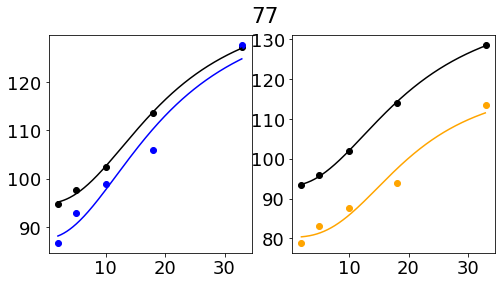

77
1.6658536680099438 0.8015705632488273 2.588223465825201 0.1638312490998331
3.7501488875079314 4.2627242510252294 4.444593551310394 3.6789100380950845 4.444593551310394


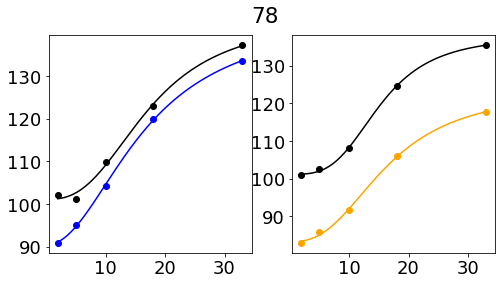

78
1.713898456653622 0.7814141137159615 3.563122468948342 0.15847536540295695
3.22643603766668 4.624514882829445 3.500753861949102 4.750926636354369 4.750926636354369


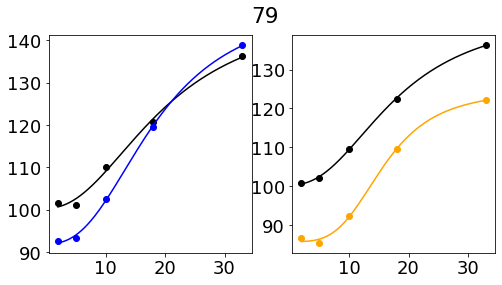

79
1.6904363899733659 0.8805238661036592 2.7937218655761225 0.19601651182883614
2.9610916672804244 4.477429335255767 3.2445775311587433 3.5676642482722176 4.477429335255767


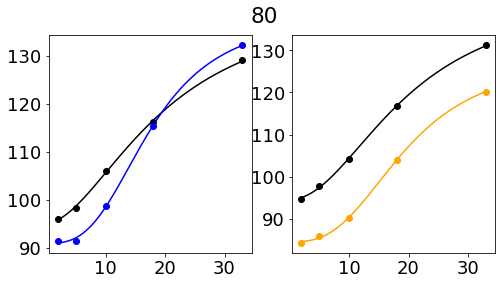

80
1.7072821705065633 0.7442632993341377 5.162857924018333 0.17834170388770182
3.443835202519585 4.6713912952336845 3.358636286322181 5.582646808601721 5.582646808601721


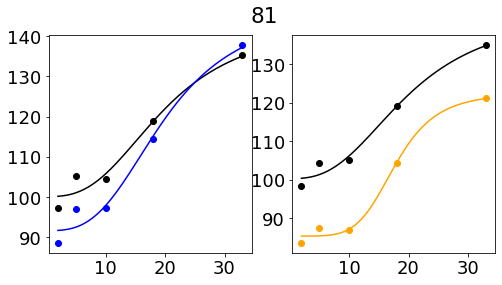

81
1.8233916125480325 0.9886015529293148 2.732826385708989 0.19999999999999998
3.0485529881521867 4.301692301482163 3.185709105096457 3.8667740755609525 4.301692301482163


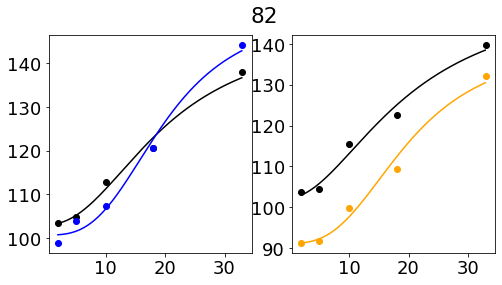

82
1.5041653152361152 0.8268297520666894 1.953429302328078 0.19999999999997464
2.6439048275735066 3.0547266000149564 2.842072643830962 2.655364504662727 3.0547266000149564


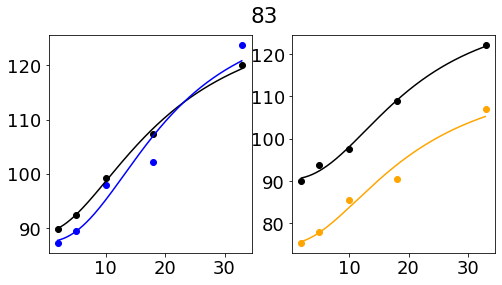

83
1.623073946206738 1.0338492126748215 2.0830849674411582 0.19999999999999982
3.4185647374060046 3.6393850423245055 3.227258019857837 3.418508353523819 3.6393850423245055


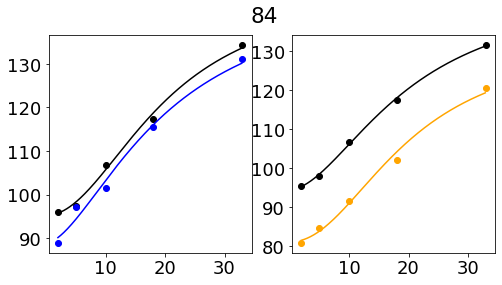

84
1.5580945961031907 0.887398811780203 2.239759842051625 0.1910050501495503
2.871487233538428 3.716490356292601 2.533985005547157 3.1965302124917994 3.716490356292601


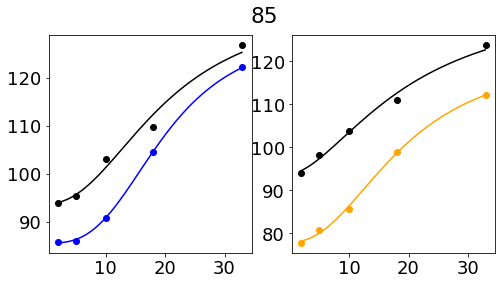

85
1.669720604548341 1.021371541241543 1.6153822115638463 0.19999999999999998
3.9192376124660644 3.419579681185736 4.012688219706861 3.1118403130944605 4.012688219706861


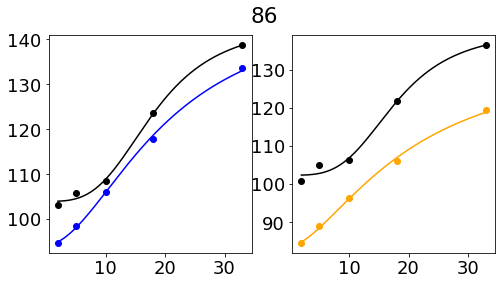

86
1.6104615803208777 1.0365111382734242 1.5677767415502362 0.18141867623186367
2.6986716071095707 3.664286504609837 2.8280351125999914 3.4703286371570607 3.664286504609837


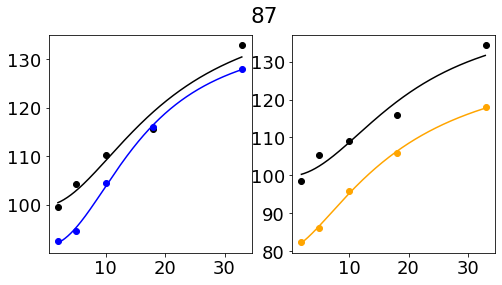

87
1.5666014963449642 1.0328584328514923 1.7781195816115842 0.19999999999999982
3.269643861491911 3.7084552200197463 3.584048946763385 3.207860861035483 3.7084552200197463


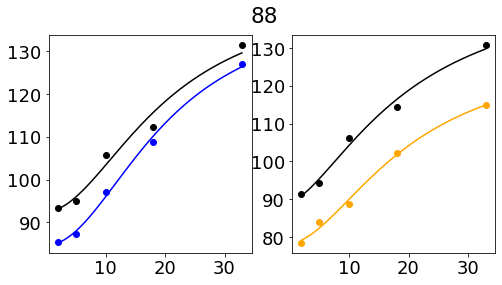

88
1.6199579343102726 1.0053733801357914 1.8831933005624275 0.19999999999999998
3.0315537200741094 3.684804970775035 2.9962240067263224 3.182993186744487 3.684804970775035


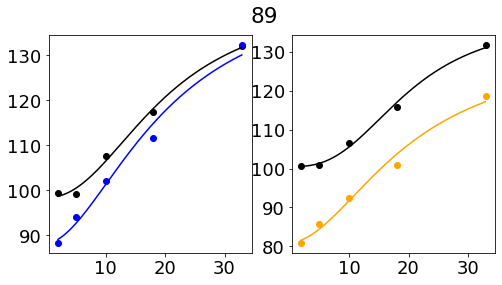

89
1.645319439362519 1.0404181152457601 2.110224851602187 0.19816379867959147
3.797176373770972 4.456926267608763 3.6312923315395818 3.4955908162181304 4.456926267608763


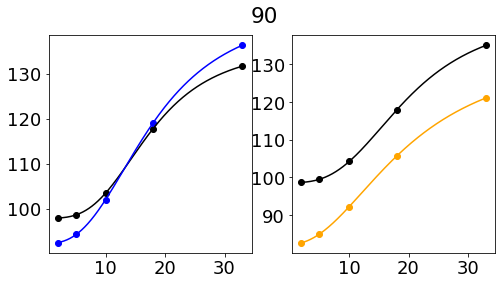

90
1.7061742669930875 1.0252139328063155 2.5103871047287614 0.19999999999999998
3.499878784396282 4.264045176958042 3.110802899412235 3.7842539355566363 4.264045176958042


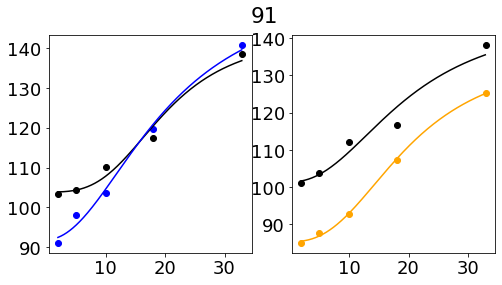

91
1.6695199187368506 1.0366953686544682 2.454593710241937 0.19999999999999998
2.965331714717756 4.1701850978522526 2.889929035177463 3.7672411631084257 4.1701850978522526


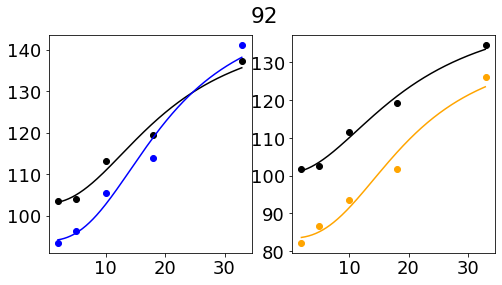

92
1.7663366840828583 0.9068802645536794 2.4073661949276 0.19999999999999207
3.18892681089169 3.8776994478895155 3.3573800632281436 3.2559624851141056 3.8776994478895155


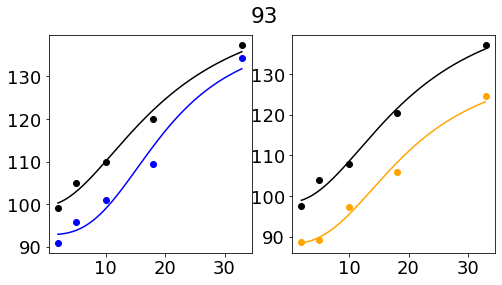

93
1.6238113377996473 0.9893704273185618 2.2629758692077564 0.19999999999999998
3.410005811403116 4.138897881913506 2.7958684032427072 3.4216631192119262 4.138897881913506


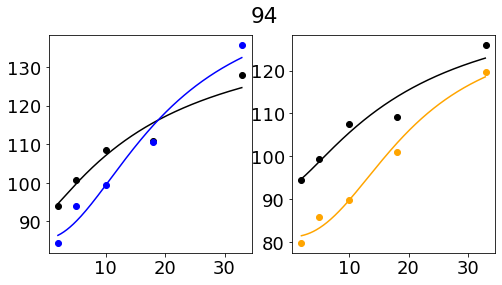

94
1.6877629465078894 0.9968034722893931 2.184126394927163 0.19999999999999998
4.829174133841185 3.952327526458088 4.0388629953647115 3.3805016329371496 4.829174133841185


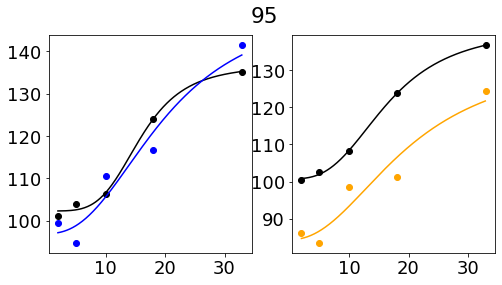

95
1.7252440541351177 0.9368683032709386 3.6638875347593003 0.19999999999999998
3.772044351553916 3.930427634464806 4.449897834334093 4.6176814633457575 4.6176814633457575


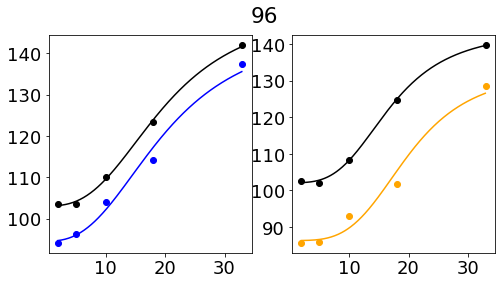

96
1.7608146719417619 0.761682403155856 5.635464809175899 0.19999999999999984
3.292616951214722 4.362888326414582 3.343553745359884 5.519150040789311 5.519150040789311


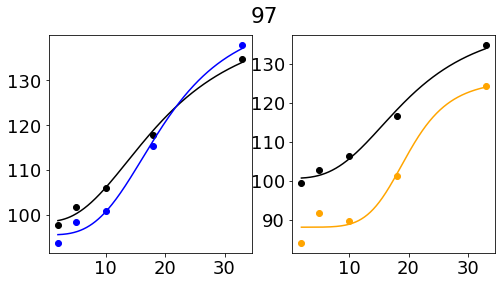

97
1.7085556274153986 0.9440592883121195 2.163693402151826 0.19999999999999998
3.996106163476476 3.939713283173507 3.773834969400891 3.186080171241845 3.996106163476476


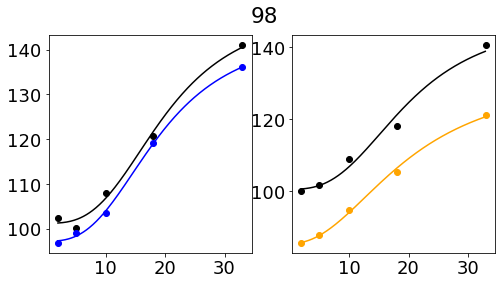

98
1.7464514843293986 0.9215611984092179 3.310118380671568 0.19275427323766334
3.3265690859901387 4.263831807800589 3.419587745663488 4.327705996926534 4.327705996926534


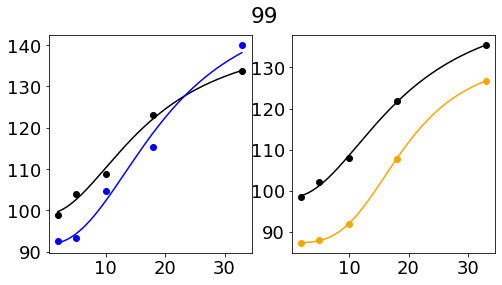

99
1.727332292931266 1.1157635726530328 1.9665020515343719 0.1999999999999997
3.284779088882628 4.048160680745072 3.5159010299142146 3.594338142219611 4.048160680745072


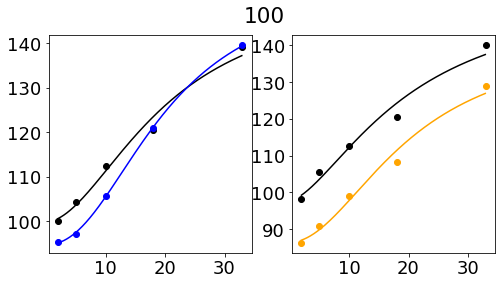

100


In [52]:
simname = 'base3t'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.1, 0.18])
ignor=0
slopes_cp, slopes_sp, slopes_cs, slopes_ss = [], [], [], []
binlen = 60

ctrl_pv_ave = np.zeros(5)
stim_pv_ave = np.zeros(5)
ctrl_sst_ave = np.zeros(5)
stim_sst_ave = np.zeros(5)

for seed in range(1,101):
    # contrasts = np.array([0.02, 0.05, 0.2, 0.3])
    # contrasts = np.array([0.02,  0.2])
    ctrl_pv_curve = [[] for i in range(4)]
    stim_pv_curve = [[] for i in range(4)]
    ctrl_sst_curve = [[] for i in range(4)]
    stim_sst_curve = [[] for i in range(4)]

    ctrl_pv_curve_e = [[] for i in range(4)]
    stim_pv_curve_e = [[] for i in range(4)]
    ctrl_sst_curve_e = [[] for i in range(4)]
    stim_sst_curve_e = [[] for i in range(4)]

    
    folder = 'data/%s/results_%s/'%(simname, seed)
    not_all_found=False
    for cont in contrasts:
        try:
            with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            break

        ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen=binlen)
        ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen=binlen)
        ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen=binlen)
        ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err = getStimRateMeans(all_spikes, all_positions, binlen=binlen)

        ctrl_pv_curve[0].append(ctrlpv_E_mean)
        ctrl_pv_curve[1].append(ctrlpv_P_mean)
        ctrl_pv_curve[2].append(ctrlpv_S_mean)
        ctrl_pv_curve[3].append(ctrlpv_A_mean)
        ctrl_pv_curve_e[0].append(ctrlpv_E_err)
        ctrl_pv_curve_e[1].append(ctrlpv_P_err)
        ctrl_pv_curve_e[2].append(ctrlpv_S_err)
        ctrl_pv_curve_e[3].append(ctrlpv_A_err)

        stim_pv_curve[0].append(stimpv_E_mean)
        stim_pv_curve[1].append(stimpv_P_mean)
        stim_pv_curve[2].append(stimpv_S_mean)
        stim_pv_curve[3].append(stimpv_A_mean)
        stim_pv_curve_e[0].append(stimpv_E_err)
        stim_pv_curve_e[1].append(stimpv_P_err)
        stim_pv_curve_e[2].append(stimpv_S_err)
        stim_pv_curve_e[3].append(stimpv_A_err)
        
        ctrl_pv_ave += ctrlpv_A_mean
        stim_pv_ave += stimpv_A_mean
        ctrl_sst_ave += ctrlsst_A_mean
        stim_sst_ave += stimsst_A_mean

        try:
            with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            break

        ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen= binlen)
        ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen= binlen)
        ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen= binlen)
        ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err = getStimRateMeans(all_spikes, all_positions, binlen= binlen)


        ctrl_sst_curve[0].append(ctrlsst_E_mean)
        ctrl_sst_curve[1].append(ctrlsst_P_mean)
        ctrl_sst_curve[2].append(ctrlsst_S_mean)
        ctrl_sst_curve[3].append(ctrlsst_A_mean)
        ctrl_sst_curve_e[0].append(ctrlsst_E_err)
        ctrl_sst_curve_e[1].append(ctrlsst_P_err)
        ctrl_sst_curve_e[2].append(ctrlsst_S_err)
        ctrl_sst_curve_e[3].append(ctrlsst_A_err)

        stim_sst_curve[0].append(stimsst_E_mean)
        stim_sst_curve[1].append(stimsst_P_mean)
        stim_sst_curve[2].append(stimsst_S_mean)
        stim_sst_curve[3].append(stimsst_A_mean)
        stim_sst_curve_e[0].append(stimsst_E_err)
        stim_sst_curve_e[1].append(stimsst_P_err)
        stim_sst_curve_e[2].append(stimsst_S_err)
        stim_sst_curve_e[3].append(stimsst_A_err)
    # contrasts = np.array([ 0.05, 0.1, 0.2, 0.3])
    
    if not_all_found:
        continue
        
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_pv_curve[3][ignor:], sigma=ctrl_pv_curve_e[3][ignor:])
    m_cp, C_cp, n_cp, k_cp = params
    m_cp_err, C_cp_err, n_cp_err, k_cp_err = np.sqrt(np.diag(cov))
#     slope_cp = C_cp*n_cp/k_cp/4.0
    slope_cp, _ = get_slope(m_cp, C_cp, n_cp, k_cp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_pv_curve[3][ignor:], sigma=stim_pv_curve_e[3][ignor:])
    m_sp, C_sp, n_sp, k_sp = params
    m_sp_err, C_sp_err, n_sp_err, k_sp_err = np.sqrt(np.diag(cov))
#     slope_sp = C_sp*n_sp/k_sp/4.0
    slope_sp, _ = get_slope(m_sp, C_sp, n_sp, k_sp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_sst_curve[3][ignor:], sigma=ctrl_sst_curve_e[3][ignor:])
    m_cs, C_cs, n_cs, k_cs = params
    m_cs_err, C_cs_err, n_cs_err, k_cs_err = np.sqrt(np.diag(cov))
#     slope_cs = C_cs*n_cs/k_cs/4.0
    slope_cs, _ = get_slope(m_cs, C_cs, n_cs, k_cs)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_sst_curve[3][ignor:], sigma=stim_sst_curve_e[3][ignor:])
    m_ss, C_ss, n_ss, k_ss = params
    m_ss_err, C_ss_err, n_ss_err, k_ss_err = np.sqrt(np.diag(cov))
#     slope_ss = C_ss*n_ss/k_ss/4.0
    slope_ss, _ = get_slope(m_ss, C_ss, n_ss, k_ss)
    
    
#     if np.max( [slope_cp, slope_sp, slope_cs, slope_ss] ) >50: continue
    slopes_cp.append(slope_cp)
    slopes_sp.append(slope_sp)
    slopes_cs.append(slope_cs)
    slopes_ss.append(slope_ss)
    
    print(m_ss, C_ss, n_ss, k_ss)
    
    print(slope_cp, slope_sp, slope_cs, slope_ss, np.max( [slope_cp, slope_sp, slope_cs, slope_ss] ) )
    
    scal = 50
    cvals = np.arange(0.02,0.33,0.001)
    fig,axes = plt.subplots(1,2,figsize = (8,4))
    axes[0].scatter(contrasts*100, np.array(ctrl_pv_curve[3])*scal, c='black')
    axes[0].scatter(contrasts*100, np.array(stim_pv_curve[3])*scal, c='blue')
    yvals = naka_rushton(cvals, m_cp, C_cp, n_cp, k_cp)
    axes[0].plot(cvals*100, yvals*scal, c='black')
    yvals = naka_rushton(cvals, m_sp, C_sp, n_sp, k_sp)
    axes[0].plot(cvals*100, yvals*scal, c='blue')
    
    axes[1].scatter(contrasts*100, np.array(ctrl_sst_curve[3])*scal, c='black')
    axes[1].scatter(contrasts*100, np.array(stim_sst_curve[3])*scal, c='orange')
    yvals = naka_rushton(cvals, m_cs, C_cs, n_cs, k_cs)
    axes[1].plot(cvals*100, yvals*scal, c='black')
    yvals = naka_rushton(cvals, m_ss, C_ss, n_ss, k_ss)
    axes[1].plot(cvals*100, yvals*scal, c='orange')
    plt.suptitle(seed)
    plt.show()
    
    print(seed)
    
ctrl_pv_ave = ctrl_pv_ave/100.
stim_pv_ave = stim_pv_ave/100.
ctrl_sst_ave = ctrl_sst_ave/100.
stim_sst_ave = stim_sst_ave/100.

In [53]:
all_slopes = [slopes_cp, slopes_sp, slopes_cs, slopes_ss]
with open('short_nl.txt', 'wb') as f:
    pickle.dump(all_slopes, f)

In [41]:
len(slopes_cp)

61

In [49]:
scipy.stats.ranksums(slopes_cp, slopes_sp)


RanksumsResult(statistic=-4.161911325623474, pvalue=3.155949088537943e-05)

In [50]:
scipy.stats.ranksums(slopes_cs, slopes_ss)

RanksumsResult(statistic=-0.3977584250595861, pvalue=0.6908082660253129)

In [51]:
scipy.stats.ttest_ind(slopes_cs, slopes_ss)

Ttest_indResult(statistic=0.01293080252837206, pvalue=0.989736596593475)

In [52]:
print(scipy.stats.ranksums(slopes_cp, slopes_sp))
print(scipy.stats.ranksums(slopes_cs, slopes_ss))
print(np.median(slopes_cp), np.median(slopes_sp))
print(np.median(slopes_cs), np.median(slopes_ss))

3.4325783736762094 3.9115741054432718
3.2980116295034723 3.365476561745817


In [53]:
np.median(slopes_ss)/np.median(slopes_cs)

1.0204562444955665

In [54]:
print(np.median(slopes_cp), np.median(slopes_sp))
print(np.median(slopes_cs), np.median(slopes_ss))
print(np.median(slopes_ss)/np.median(slopes_cs))

3.4325783736762094 3.9115741054432718
3.2980116295034723 3.365476561745817
1.0204562444955665


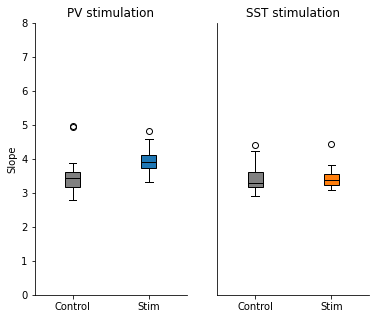

In [55]:
# Create a figure and axis object
fig, axes = plt.subplots(1,2, figsize = (6,5))


# Create the box and whisker plot
# ax.boxplot([slopes_cp, slopes_sp], widths=0.5, patch_artist=True, boxprops=dict(facecolor=box_colors, color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='black'))

ax = axes[0]
box_colors = ['gray', 'tab:blue']
# Create the box and whisker plot
bp = ax.boxplot([slopes_cp, slopes_sp], widths=0.2, patch_artist=True, boxprops=dict(facecolor=box_colors[0], color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='black'))

# Set the facecolor for the Y box
for pi, patch in enumerate(bp['boxes']):
    patch.set_facecolor(box_colors[pi])
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-tick labels
ax.set_xticklabels(['Control', 'Stim'])

# Set the y-axis label
# ax.set_ylabel('Value')
ax.set_ylabel('Slope')


# Set the title of the plot
ax.set_title('PV stimulation')

ax = axes[1]
box_colors = ['gray', 'tab:orange']

# Create the box and whisker plot
bp = ax.boxplot([slopes_cs, slopes_ss], widths=0.2, patch_artist=True, boxprops=dict(facecolor=box_colors[0], color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='black'))

# Set the facecolor for the Y box
for pi, patch in enumerate(bp['boxes']):
    patch.set_facecolor(box_colors[pi])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-tick labels
ax.set_xticklabels(['Control', 'Stim'])

# Set the y-axis label




# Set the title of the plot
ax.set_title('SST stimulation')
ax.set_yticks([])

for ax in axes:
    ax.set_ylim(0,8)


# Show the plot
plt.savefig('comp.eps')

/usr/local/pace-apps/manual/packages/anaconda3/2022.05/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/pace-apps/manual/packages/anaconda3/2022.05/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: Neither the `x` nor `y` variable appears to be numeric.

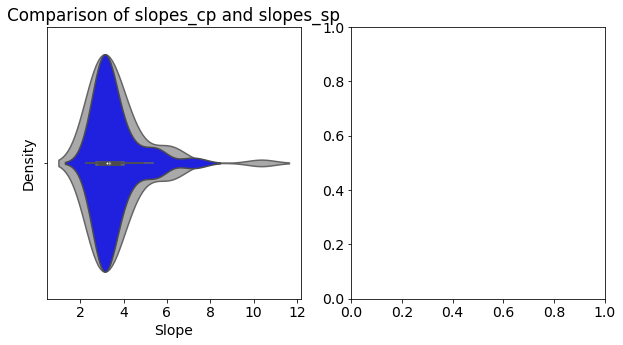

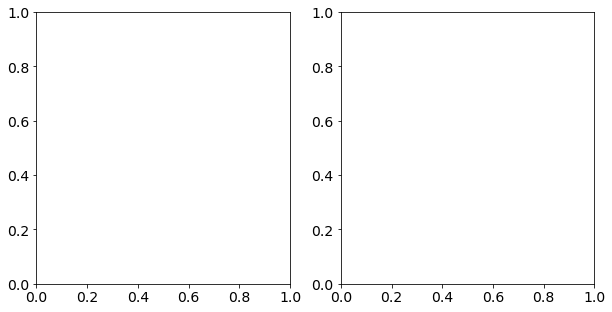

In [20]:
import seaborn as sns

slopes_cp = np.array(slopes_cp)
slopes_sp = np.array(slopes_sp)
slopes_cs = np.array(slopes_cs)
slopes_ss = np.array(slopes_ss)

# Set up the figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Left subplot
sns.violinplot(slopes_cp, x=0, shade=True, color='darkgray', ax=axes[0])
sns.violinplot(slopes_sp, x=1, shade=True, color='blue', ax=axes[0])
axes[0].set_xlabel('Slope')
axes[0].set_ylabel('Density')
axes[0].set_title('Comparison of slopes_cp and slopes_sp')

# Set up the figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Left subplot
sns.violinplot(x=['slopes_cp', 'slopes_sp'], y=[slopes_cp, slopes_sp], 
               color=['darkgray', 'blue'], ax=axes[0])

axes[0].set_ylabel('Slope')
axes[0].set_title('Comparison of slopes_cp and slopes_sp')

# Right subplot
sns.violinplot(x=['slopes_cs', 'slopes_ss'], y=[slopes_cs, slopes_ss], 
               color=['darkgray', 'orange'], ax=axes[1])
axes[1].set_ylabel('Slope')
axes[1].set_title('Comparison of slopes_cs and slopes_ss')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [34]:
with open('short_nl.txt', 'rb') as f:
    all_slopes = pickle.load( f)
    
slopes_cp, slopes_sp, slopes_cs, slopes_ss = all_slopes

(array([45., 30., 13.,  5.,  5.,  1.,  0.,  0.,  0.,  1.]),
 array([ 2.26544804,  3.07491777,  3.8843875 ,  4.69385723,  5.50332696,
         6.31279669,  7.12226642,  7.93173615,  8.74120587,  9.5506756 ,
        10.36014533]),
 <BarContainer object of 10 artists>)

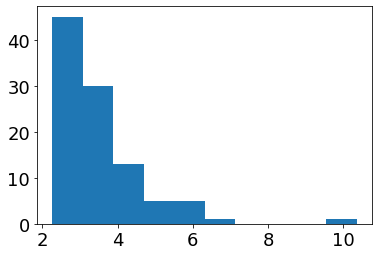

In [9]:
plt.hist(slopes_cp)

In [35]:
PV_changes = []
for ii in range(len(slopes_cp)):
    PV_changes.append( (slopes_sp[ii]-slopes_cp[ii]) / (slopes_sp[ii]+slopes_cp[ii]) )
    
SST_changes = []
for ii in range(len(slopes_cs)):
    SST_changes.append( (slopes_ss[ii]-slopes_cs[ii]) / (slopes_ss[ii]+slopes_cs[ii])  )

In [37]:
f = open('stats_short_nonlin.txt','w')
f.write("PV stim MI median = %s, MAD = %s\n"%(np.median(PV_changes), scipy.stats.median_abs_deviation(PV_changes)))
f.write("SST stim MI median = %s, MAD = %s\n"%(np.median(SST_changes), scipy.stats.median_abs_deviation(SST_changes)))
stat, pval = scipy.stats.ranksums(PV_changes, SST_changes)
f.write("PV MI vs SST MI rank sum test. statistic = %s, p-value = %s\n"%(stat, pval))
stat, pval = scipy.stats.ranksums(slopes_sp, slopes_cp)
f.write("PV Stim slope vs Control slope signed-ranked test. statistic = %s, p-value = %s\n"%(stat, pval))
stat, pval = scipy.stats.ranksums(slopes_ss, slopes_cs)
f.write("SST Stim slope vs Control slope signed-ranked test. statistic = %s, p-value = %s\n"%(stat, pval))
f.close()

In [11]:
sstcolor = (0.898,0.6314,0.0039)
pvcolor = (0.0, 0.4039, 0.7059)

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import seaborn as sns

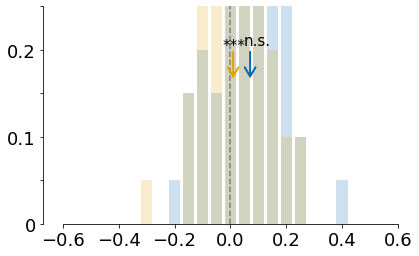

In [68]:
bins = np.arange(-0.525,0.5, 0.05)
fig, ax = plt.subplots()
pvn, pvbins, _ = ax.hist(PV_changes, bins=bins, facecolor=pvcolor, alpha=0.2, rwidth=0.8)
sstn, sstbins, _ = ax.hist(SST_changes, bins=bins, facecolor=sstcolor, alpha=0.2, rwidth=0.8)
ax.plot([0,0],[0,5], '--', c='gray')
# ax.arrow( np.median(PV_changes), 3 , 0, -0.5, width=0.01)
ax.annotate("", xytext=(np.median(PV_changes), 4), xy=(np.median(PV_changes), 3.3),
            arrowprops=dict(arrowstyle="->, head_length = 0.5, head_width = .3", lw=2, color=pvcolor))
ax.annotate("", xytext=(np.median(SST_changes), 4), xy=(np.median(SST_changes), 3.3),
            arrowprops=dict(arrowstyle="->, head_length = 0.5, head_width = .3", lw=2, color=sstcolor))
ax.text(np.median(SST_changes)-0.038, 4, "***", size=15)
ax.text(np.median(PV_changes)-0.023, 4.1, "n.s.", size=15)

ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
ax.set_ylim(0,5)
# ax.set_ylim(0,9.)
ax.set_xlim(-0.6,0.6)

sns.despine(offset={'left':20})
# plt.savefig('base.svg')
plt.show()

In [69]:
np.median(SST_changes)

0.00985062711208398

In [70]:
np.median(PV_changes)

0.07088763168059846

In [21]:
data = np.array([pvbins[:-1], pvn, sstn])

In [58]:
sstn

array([ 0.,  1.,  5.,  3.,  3.,  4.,  9., 14., 11.,  9., 10.,  7., 11.,
        4.,  4.,  2.,  3.,  0.,  0.,  0.])

In [71]:
from scipy.io import savemat
import numpy as np

mdic = {"bins": pvbins, "PV": pvn, "SST": sstn, 'PV_median': np.median(PV_changes), 'SST_median': np.median(SST_changes)}

savemat("raw/short_nonlinear.mat", mdic)

In [60]:
from scipy.io import loadmat
a =loadmat('raw/base.mat')

In [61]:
a

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Mar  4 16:52:50 2023',
 '__version__': '1.0',
 '__globals__': [],
 'bins': array([[-0.525, -0.475, -0.425, -0.375, -0.325, -0.275, -0.225, -0.175,
         -0.125, -0.075, -0.025,  0.025,  0.075,  0.125,  0.175,  0.225,
          0.275,  0.325,  0.375,  0.425,  0.475]]),
 'PV': array([[ 0.,  0.,  2.,  3.,  2.,  2.,  4.,  6.,  9.,  9., 12., 16., 12.,
          8.,  6.,  2.,  1.,  2.,  1.,  2.]]),
 'SST': array([[ 0.,  1.,  5.,  3.,  3.,  4.,  9., 14., 11.,  9., 10.,  7., 11.,
          4.,  4.,  2.,  3.,  0.,  0.,  0.]]),
 'PV_median': array([[0.03123849]]),
 'SST_median': array([[-0.07492305]])}

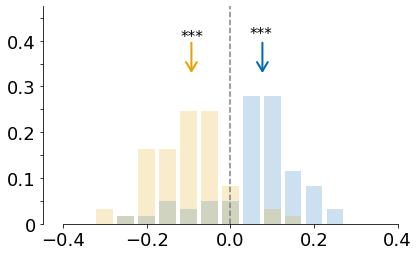

In [49]:
bins = np.arange(-0.525,0.5, 0.05)
fig, ax = plt.subplots()
ax.hist(PV_changes, bins=bins, facecolor=pvcolor, alpha=0.2, rwidth=0.8, density=True)
ax.hist(SST_changes, bins=bins, facecolor=sstcolor, alpha=0.2, rwidth=0.8, density=True)
ax.plot([0,0],[0,15], '--', c='gray')
# ax.arrow( np.median(PV_changes), 3 , 0, -0.5, width=0.01)
ax.annotate("", xytext=(np.median(PV_changes), 8), xy=(np.median(PV_changes), 6.5),
            arrowprops=dict(arrowstyle="->, head_length = 0.5, head_width = .3", lw=2, color=pvcolor))
ax.annotate("", xytext=(np.median(SST_changes), 8), xy=(np.median(SST_changes), 6.5),
            arrowprops=dict(arrowstyle="->, head_length = 0.5, head_width = .3", lw=2, color=sstcolor))
ax.text(np.median(SST_changes)-0.025, 8, "***", size=15)
ax.text(np.median(PV_changes)-0.03, 8.1, "***", size=15)

ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
ax.set_ylim(0,9.5)
ax.set_xlim(-0.4,0.4)

sns.despine(offset={'left':20})
plt.savefig('nl.svg')

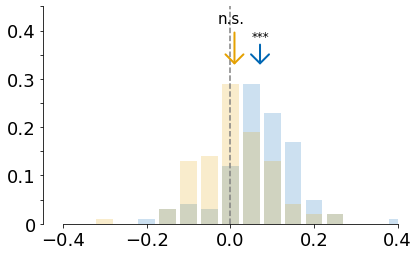

In [55]:
##### bins = np.arange(-0.525,0.5, 0.05)
fig, ax = plt.subplots()

ax.hist(PV_changes, bins=bins, facecolor=pvcolor, alpha=0.2, rwidth=0.8, density=True)
ax.hist(SST_changes, bins=bins, facecolor=sstcolor, alpha=0.2, rwidth=0.8, density=True)
ax.plot([0,0],[0,15], '--', c='gray')
# ax.arrow( np.median(PV_changes), 3 , 0, -0.5, width=0.01)
ax.annotate("", xytext=(np.median(PV_changes), 7.5), xy=(np.median(PV_changes), 6.5),
            arrowprops=dict(arrowstyle="->, head_length = 0.5, head_width = .5", lw=2, color=pvcolor))
ax.annotate("", xytext=(np.median(SST_changes), 8), xy=(np.median(SST_changes), 6.5),
            arrowprops=dict(arrowstyle="->, head_length = 0.5, head_width = .5", lw=2, color=sstcolor))
ax.text(np.median(SST_changes)-0.04, 8.3, "n.s.", size=15)
ax.text(np.median(PV_changes)-0.02, 7.6, "***", size=12)

ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
ax.set_ylim(0,9.)
ax.set_xlim(-0.4,0.4)

sns.despine(offset={'left':20})
plt.savefig('nl_short.svg')

In [21]:
stat, pval = scipy.stats.ranksums(slopes_cp, slopes_sp)

In [22]:
stat

-1.2681188324184482

In [23]:
pval

0.20475551717384544

In [24]:
print(scipy.stats.ranksums(slopes_cp, slopes_sp))
print(scipy.stats.ranksums(slopes_cs, slopes_ss))
print(np.median(slopes_cp), np.median(slopes_sp))
print(np.median(slopes_cs), np.median(slopes_ss))

RanksumsResult(statistic=-1.2681188324184482, pvalue=0.20475551717384544)
RanksumsResult(statistic=4.153761108114377, pvalue=3.2705462235166057e-05)
3.2086612437814743 3.2537779931046784
3.2019318982690503 2.7390979999362353


In [13]:
print((np.median(slopes_sp) - np.median(slopes_cp))/ np.std(slopes_cp) )
print((np.median(slopes_ss) - np.median(slopes_cs))/ np.std(slopes_cs) )

0.9802635614469921
0.08279115129380758


In [10]:
len(slopes_sp)

100

In [13]:
scipy.stats.wilcoxon

<module 'scipy' from '/usr/local/pace-apps/manual/packages/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py'>